# Human Tests 2
---
#### Started: 9 March 2022  |  Last updated: 12 August 2022
---
Inspecting results.  Administrator manually recorded time in minutes.  The 45 minute limit was not strictly enforced, but reviewers were encouraged to hurry up if they exceeded that limit.

Some of the specific questions asked were:
- What was the environment?
- How many male and how many female speakers were there?  Some participants marked this directly in the labels.
- What did you make of the recording and sound quality?

To consider: lots of collars mean more time excluded, does this mean that specifying more segments artificially makes those results look good?

1 April 2022 Update: I have been using segments based on vocal sounds (e.g. laughter, coughing) as well as words.  Following the BUT teams files I am now limiting to words only, and results are improving significantly.  I need to retrain the models on this training data though.  https://github.com/BUTSpeechFIT/AMI-diarization-setup/tree/b158cbecae7c91298346c6bec1d6dcad473f61d3/only_words/rttms/train

12 April 2022 Update - I am updating various parts for consistency with the version on my desktop, which I was using when HPC was down.  I am also introducing GT4 as the BUT ground truth with words and non-lexical sounds.

<ul>
    <li>GT1 = AMI segments</li>
    <li>GT2 = AMI segments minus ones with non-lexical sounds only</li>
    <li>GT3 = BUT words only, based on AMI words</li>
    <li>GT4 = BUT words and non-lexical sounds, based on AMI words and non-lexical sounds</li>
</ul>

11 August 2022 Update - I have added ``pyannote.audio`` data for GT3 as (a) it does not need a GT and (b) the results are better than even the best human reviewer.

In [1]:
import subprocess
import AnalyseResults, OverlapFunctions
from IPython.display import display
import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from natsort import natsorted

In [2]:
def runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile):
    myoutput = open(outputDir+"NISTEvaluation_2_5.txt", 'w')
    subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.25", "-u", uemFile, "-r", oracleRttmFile, "-s", outputDir+audioname+".rttm"], stdout=myoutput)
    myoutput = open(outputDir+"NISTEvaluation_2_0.txt", 'w')
    subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.20", "-u", uemFile, "-r", oracleRttmFile, "-s", outputDir+audioname+".rttm"], stdout=myoutput)
    myoutput = open(outputDir+"NISTEvaluation_1_5.txt", 'w')
    subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.15", "-u", uemFile, "-r", oracleRttmFile, "-s", outputDir+audioname+".rttm"], stdout=myoutput)
    myoutput = open(outputDir+"NISTEvaluation_1_0.txt", 'w')
    subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.10", "-u", uemFile, "-r", oracleRttmFile, "-s", outputDir+audioname+".rttm"], stdout=myoutput)
    myoutput = open(outputDir+"NISTEvaluation_0_5.txt", 'w')
    subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.05", "-u", uemFile, "-r", oracleRttmFile, "-s", outputDir+audioname+".rttm"], stdout=myoutput)
    myoutput = open(outputDir+"NISTEvaluation_0_0.txt", 'w')
    subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.00", "-u", uemFile, "-r", oracleRttmFile, "-s", outputDir+audioname+".rttm"], stdout=myoutput)

    print("Running md-eval-v21.pl scripts complete")
    return 1

## Main Reviews

In [21]:
# Review times manually recorded in minutes
review_times = [26, 47, 55, 67, 35, 54, 42, 38, 37, 47, 45, 41, 38]

In [22]:
rpath = "../../HumanReviews/Reviews/"
lst_reviews = [file[:-4] for file in os.listdir(rpath)]
# for i in range(len(lst_reviews)):
#     if lst_reviews[i][-2] == "r":
#         lst_reviews[i] = lst_reviews[i][:8] + "0" + lst_reviews[i][-1]
#lst_reviews.sort()
lst_reviews = natsorted(lst_reviews)
lst_reviews

['Reviewer1',
 'Reviewer2',
 'Reviewer3',
 'Reviewer4',
 'Reviewer5',
 'Reviewer6',
 'Reviewer7',
 'Reviewer8',
 'Reviewer9',
 'Reviewer10',
 'Reviewer11',
 'Reviewer12',
 'Reviewer13']

### GT1

In [178]:
dfs = []
counts = []
agg_times = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "rttm_laugh/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 1: 35
Total speech time predicted by reviewer 1: 246.92
Comb speech time predicted by reviewer 1: 240.24
Percent overlapping speech predicted by reviewer 1: 2.78%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 2: 37
Total speech time predicted by reviewer 2: 228.53
Comb speech time predicted by reviewer 2: 220.72
Percent overlapping speech predicted by reviewer 2: 3.54%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1', '2', '3', '4', '5']
Number of speaker segments predicted by reviewer 3: 55
Total speech time predicted by reviewer 3: 219.58
Comb speech time predicted by reviewer 3: 218.33
Percent overlapping speech predicted by reviewer 3: 0.57%
Running md-eval-v21.pl scripts complete

Check set of predicted speake

Running md-eval-v21.pl scripts complete



In [179]:
for i in range(len(review_times)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.87,4.35,0.98,11.20
1,200,6.45,4.91,1.11,12.46
2,150,7.02,5.52,1.25,13.79
3,100,7.64,6.12,1.41,15.16
4,50,8.33,6.75,1.60,16.68
5,0,9.09,7.45,1.82,18.36


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,10.41,1.73,1.49,13.62
1,200,10.93,2.10,1.63,14.66
2,150,11.45,2.63,1.76,15.84
3,100,11.98,3.12,1.92,17.02
4,50,12.55,3.64,2.08,18.28
5,0,13.24,4.27,2.29,19.80


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,12.01,0.62,0.75,13.38
1,200,12.59,0.77,0.99,14.36
2,150,13.20,1.00,1.21,15.40
3,100,13.97,1.28,1.36,16.61
4,50,14.93,1.61,1.52,18.06
5,0,16.08,2.06,1.68,19.81


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.59,1.21,1.99,10.78
1,200,8.41,1.45,2.13,11.99
2,150,9.37,1.76,2.31,13.43
3,100,10.40,2.11,2.50,15.02
4,50,11.56,2.51,2.69,16.75
5,0,12.78,2.96,2.86,18.60


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.53,5.50,1.67,15.70
1,200,9.37,6.07,1.85,17.29
2,150,10.21,6.73,2.06,19.00
3,100,11.09,7.39,2.25,20.73
4,50,12.00,8.05,2.43,22.47
5,0,12.93,8.74,2.61,24.28


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,24.23,0.18,2.20,26.60
1,200,25.11,0.22,2.34,27.68
2,150,26.13,0.26,2.45,28.84
3,100,27.44,0.33,2.50,30.27
4,50,28.94,0.42,2.50,31.86
5,0,30.54,0.59,2.50,33.64


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.03,0.72,1.06,9.81
1,200,8.62,1.00,1.25,10.87
2,150,9.28,1.41,1.44,12.14
3,100,10.05,1.89,1.64,13.59
4,50,10.95,2.45,1.85,15.25
5,0,11.97,3.06,2.10,17.12


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.02,5.32,1.72,15.05
1,200,8.60,5.54,1.96,16.09
2,150,9.17,5.87,2.21,17.24
3,100,9.82,6.26,2.42,18.50
4,50,10.55,6.73,2.66,19.94
5,0,11.33,7.35,2.98,21.65


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,9.19,1.85,0.79,11.82
1,200,9.87,2.30,1.01,13.18
2,150,10.60,2.85,1.24,14.68
3,100,11.34,3.45,1.47,16.25
4,50,12.15,4.09,1.72,17.96
5,0,12.99,4.72,2.00,19.70


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,9.43,1.69,1.55,12.67
1,200,10.30,2.02,1.71,14.03
2,150,11.23,2.45,1.88,15.56
3,100,12.20,2.87,2.02,17.09
4,50,13.31,3.31,2.14,18.76
5,0,14.51,3.82,2.28,20.61


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,9.10,1.76,0.30,11.16
1,200,9.67,2.11,0.37,12.16
2,150,10.20,2.56,0.49,13.25
3,100,10.82,3.04,0.60,14.46
4,50,11.49,3.56,0.72,15.78
5,0,12.26,4.20,0.86,17.31


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.01,2.09,1.33,11.43
1,200,8.63,2.39,1.45,12.48
2,150,9.28,2.86,1.56,13.70
3,100,10.02,3.38,1.66,15.05
4,50,10.85,3.95,1.72,16.52
5,0,11.74,4.66,1.84,18.24


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.23,1.85,0.19,10.26
1,200,8.83,2.27,0.33,11.44
2,150,9.44,2.69,0.51,12.64
3,100,10.15,3.10,0.69,13.94
4,50,11.06,3.53,0.83,15.42
5,0,12.01,4.09,0.99,17.09


In [180]:
pred_spkrs_segs[1]

[46.354994, 61.81908]

In [181]:
counts

[35, 37, 55, 37, 21, 63, 48, 38, 36, 38, 47, 38, 37]

In [182]:
dfs[0].iloc[-1]["DER (%)"]

18.36

In [183]:
# Copying diarization system data from dataOdyssey2022_5

dfs_sys = []
cols = ["Collar (ms)", "MISSED (%)", "FALARM (%)", "ERROR (%)", "DER (%)"]

# Order is [CNN+LSTM, ResNet101, BDII, KF ensemble]
counts_sys = [77, 45, 53, 53]
agg_times_sys = [240.25, 248.25, 237.0, 235.5]
data1 = [[250, 10.53, 6.71, 1.91, 19.16],
        [200, 11.07, 7.17, 2.13, 20.37],
        [150, 11.63, 7.69, 2.37, 21.69],
        [100, 12.18, 8.21, 2.63, 23.02],
        [50, 12.80, 8.73, 2.87, 24.41],
        [0, 13.42, 9.31, 3.12, 25.85]]

data2 = [[250, 7.43, 5.97, 1.49, 14.88],
        [200, 8.05, 6.69, 1.64, 16.38],
        [150, 8.65, 7.39, 1.86, 17.90],
        [100, 9.32, 8.14, 2.06, 19.52],
        [50, 10.02, 8.88, 2.26, 21.16],
        [0, 10.77, 9.66, 2.43, 22.86]]

data3 = [[250, 7.34, 3.46, 0.62, 11.43],
        [200, 8.02, 4.10, 0.73, 12.85],
        [150, 8.78, 4.80, 0.88, 14.46],
        [100, 9.69, 5.50, 1.05, 16.24],
        [50, 10.64, 6.22, 1.25, 18.10],
        [0, 11.62, 6.97, 1.50, 20.09]]

data4 = [[250, 8.74, 2.31, 1.24, 12.29],
        [200, 9.26, 2.83, 1.41, 13.51],
        [150, 9.72, 3.39, 1.67, 14.78],
        [100, 10.20, 3.96, 1.92, 16.09],
        [50, 10.76, 4.53, 2.16, 17.45],
        [0, 11.40, 5.21, 2.39, 18.99]]

for dat in [data1, data2, data3, data4]:
    dfs_sys.append(pd.DataFrame(dat, columns=cols))

In [184]:
dfs_sys[2]

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.34,3.46,0.62,11.43
1,200,8.02,4.10,0.73,12.85
2,150,8.78,4.80,0.88,14.46
3,100,9.69,5.50,1.05,16.24
4,50,10.64,6.22,1.25,18.10
5,0,11.62,6.97,1.50,20.09


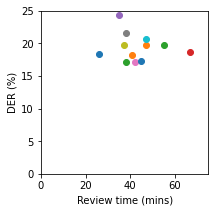

In [185]:
fig, ax = plt.subplots(figsize=(3, 3))

for i in range(len(review_times)):
    ax.scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
ax.set_xlabel("Review time (mins)")
ax.set_ylabel("DER (%)")
ax.set_xlim([0, 75])
ax.set_ylim([0, 25])

plt.show()

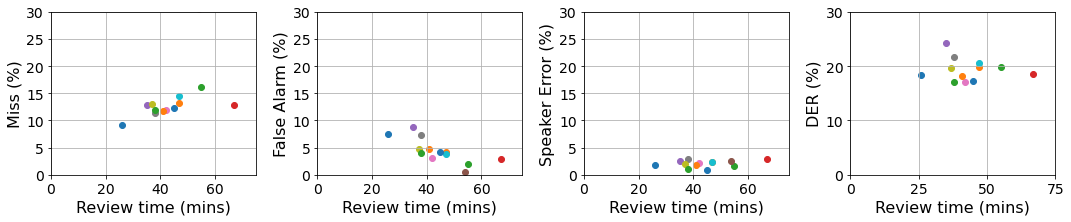

In [186]:
nPlots = 4
fig, axes = plt.subplots(1, nPlots, figsize=(18, 3))
cols = ["Miss (%)", "False Alarm (%)", "Speaker Error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(nPlots):
    axes[i].set_xlabel("Review time (mins)", fontsize=16)
    axes[i].set_ylabel(cols[i], fontsize=16)
    axes[i].set_xlim([0, 75])
    axes[i].set_ylim([0, 30])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

plt.subplots_adjust(wspace=0.3)

plt.show()

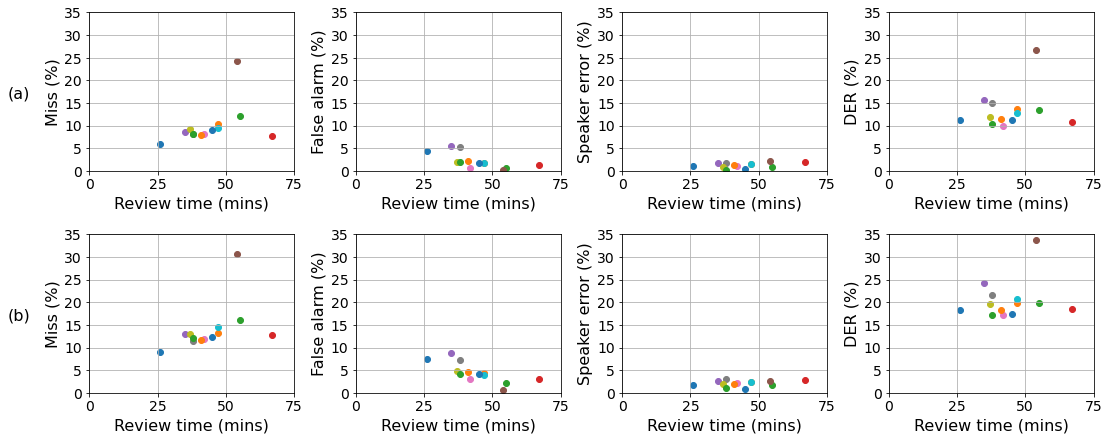

In [187]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_reviewTime_GT1.png")

plt.show()

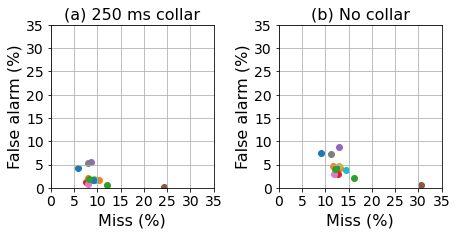

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 35])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([5*i for i in range(8)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a)", fontsize=16)
axes[1].set_title("(b)", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_missvfalarm_GT1.png")

plt.show()

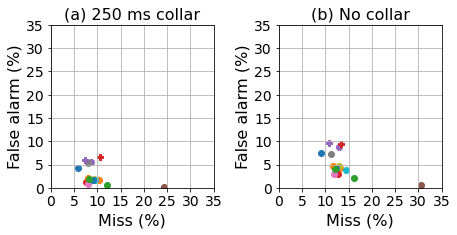

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

# System reviews
for i in range(2):
    axes[0].scatter(dfs_sys[i].iloc[0]["MISSED (%)"], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
    axes[1].scatter(dfs_sys[i].iloc[-1]["MISSED (%)"], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 35])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([5*i for i in range(8)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)
        
axes[0].set_title("(a)", fontsize=16)
axes[1].set_title("(b)", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.show()

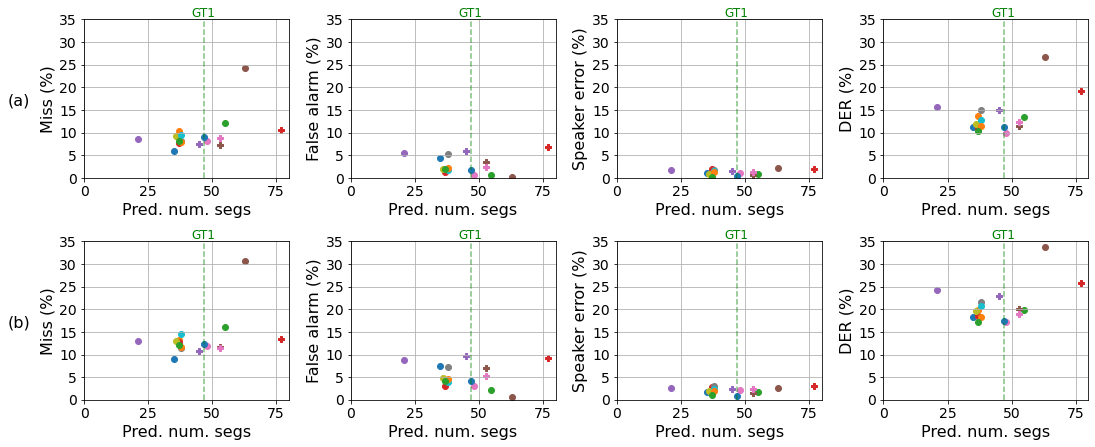

In [190]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(47, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(42, 35.5, "GT1", color="green", fontsize=12)

# System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
    axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
    axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
    axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
    axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
    axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
    axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_predNumSegs_GT1.png")

plt.show()

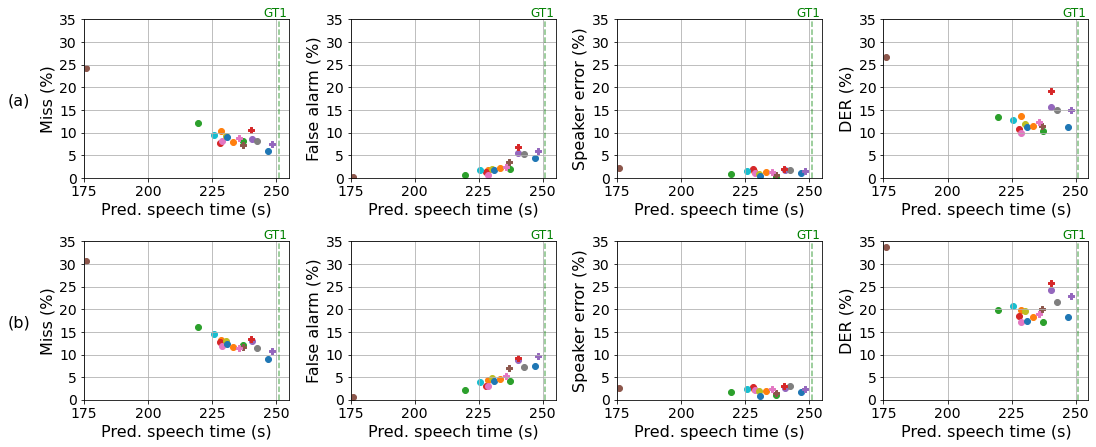

In [191]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(251.05, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(245, 35.5, "GT1", color="green", fontsize=12)
    
# System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
    axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
    axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
    axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
    axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
    axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
    axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 255])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(145, 16, "(a)",fontsize=16)
axes[1][0].text(145, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_predSpchTime_GT1.png")

plt.show()

In [139]:
ders_250 = [dfs[i].iloc[0]["DER (%)"] for i in range(len(review_times))]
ders_0 = [dfs[i].iloc[-1]["DER (%)"] for i in range(len(review_times))]
print("Mean DER with 250 ms collars for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250), np.std(ders_250)))
print("Mean DER with no collar for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0), np.std(ders_0)))

Mean DER with 250 ms collars for all reviewers is 13.34% and standard deviation is 4.19%
Mean DER with no collar for all reviewers is 20.48% and standard deviation is 4.26%


In [140]:
ders_250

[11.2,
 13.62,
 13.38,
 10.78,
 15.7,
 26.6,
 9.81,
 15.05,
 11.82,
 12.67,
 11.16,
 11.43,
 10.26]

In [141]:
d = sorted(ders_250)[:-2]
print(d)

[9.81, 10.26, 10.78, 11.16, 11.2, 11.43, 11.82, 12.67, 13.38, 13.62, 15.05]


In [142]:
ders_250_top = sorted(ders_250)[:-2]
ders_0_top = sorted(ders_0)[:-2]
print("Mean DER with 250 ms collars for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250_top), np.std(ders_250_top)))
print("Mean DER with no collar for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0_top), np.std(ders_0_top)))

Mean DER with 250 ms collars for top reviewers excluding two outliers is 11.93% and standard deviation is 1.51%
Mean DER with no collar for top reviewers excluding two outliers is 18.94% and standard deviation is 1.43%


In [143]:
# This is just looking at one speaker
ders = []
for j in range(6):
    ders.append([dfs[i].iloc[j]["DER (%)"] for i in range(len(review_times))])
    
ders_means = []
ders_stds = []
for j in range(6):
    ders_means.append(np.mean(ders[j]))
    ders_stds.append(np.std(ders[j]))
    
print("DER means for decreasing collar sizes: {}".format([round(ders_means[i], 2) for i in range(6)]))
print("DER stds for decreasing collar sizes: {}".format([round(ders_stds[i], 2) for i in range(6)]))

DER means for decreasing collar sizes: [13.34, 14.51, 15.81, 17.21, 18.75, 20.48]
DER stds for decreasing collar sizes: [4.19, 4.19, 4.19, 4.22, 4.24, 4.26]


In [144]:
# Ignoring two outliers
ders = [[], [], [], [], [], []]
for i in range(len(review_times)):
    for j in range(6):
        ders[j].append([dfs[i].iloc[j]["DER (%)"]])
    
ders_means = []
ders_stds = []
for j in range(6):
    ders_means.append(np.mean(sorted(ders[j])[:-2]))
    ders_stds.append(np.std(sorted(ders[j])[:-2]))
    
print("DER means for decreasing collar sizes: {}".format([round(ders_means[i], 2) for i in range(6)]))
print("DER stds for decreasing collar sizes: {}".format([round(ders_stds[i], 2) for i in range(6)]))

DER means for decreasing collar sizes: [11.93, 13.07, 14.33, 15.7, 17.22, 18.94]
DER stds for decreasing collar sizes: [1.51, 1.49, 1.47, 1.44, 1.43, 1.43]


Not sure why the STDs decrease with collar size...

### GT2

In [145]:
dfs = []
counts = []
agg_times = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "testingModSpecLSTM/rttm_gt2/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 1: 35
Total speech time predicted by reviewer 1: 246.92
Comb speech time predicted by reviewer 1: 240.24
Percent overlapping speech predicted by reviewer 1: 2.78%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 2: 37
Total speech time predicted by reviewer 2: 228.53
Comb speech time predicted by reviewer 2: 220.72
Percent overlapping speech predicted by reviewer 2: 3.54%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1', '2', '3', '4', '5']
Number of speaker segments predicted by reviewer 3: 55
Total speech time predicted by reviewer 3: 219.58
Comb speech time predicted by reviewer 3: 218.33
Percent overlapping speech predicted by reviewer 3: 0.57%
Running md-eval-v21.pl scripts complete

Check set of predicted speake

Running md-eval-v21.pl scripts complete



In [146]:
for i in range(len(review_times)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,4.73,5.19,0.88,10.80
1,200,5.20,5.72,0.97,11.89
2,150,5.67,6.31,1.08,13.06
3,100,6.17,6.89,1.22,14.28
4,50,6.73,7.50,1.41,15.65
5,0,7.36,8.20,1.63,17.18


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,9.07,1.93,1.47,12.48
1,200,9.41,2.30,1.62,13.33
2,150,9.76,2.81,1.77,14.33
3,100,10.14,3.30,1.94,15.38
4,50,10.59,3.83,2.12,16.54
5,0,11.14,4.48,2.35,17.97


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,10.79,0.82,0.74,12.35
1,200,11.24,0.96,0.99,13.19
2,150,11.72,1.20,1.21,14.13
3,100,12.35,1.49,1.37,15.21
4,50,13.15,1.83,1.55,16.52
5,0,14.14,2.29,1.72,18.15


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.42,1.35,1.98,9.76
1,200,7.05,1.61,2.10,10.75
2,150,7.84,1.92,2.24,12.00
3,100,8.71,2.29,2.42,13.41
4,50,9.67,2.70,2.61,14.98
5,0,10.72,3.17,2.79,16.68


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.22,5.77,1.57,14.55
1,200,7.91,6.34,1.73,15.98
2,150,8.62,7.02,1.93,17.57
3,100,9.36,7.71,2.12,19.19
4,50,10.12,8.40,2.30,20.82
5,0,10.92,9.14,2.49,22.55


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,23.58,0.18,2.17,25.93
1,200,24.22,0.22,2.33,26.77
2,150,25.02,0.26,2.46,27.74
3,100,26.13,0.34,2.52,28.99
4,50,27.41,0.43,2.54,30.38
5,0,28.78,0.60,2.56,31.96


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.92,0.97,1.27,9.16
1,200,7.32,1.24,1.43,9.99
2,150,7.79,1.65,1.58,11.02
3,100,8.36,2.13,1.74,12.23
4,50,9.06,2.68,1.93,13.67
5,0,9.90,3.29,2.15,15.33


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.72,5.60,1.61,13.93
1,200,7.16,5.85,1.82,14.83
2,150,7.61,6.21,2.04,15.87
3,100,8.12,6.65,2.23,17.01
4,50,8.72,7.17,2.46,18.35
5,0,9.36,7.82,2.77,19.95


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.02,1.83,0.78,10.63
1,200,8.48,2.29,1.01,11.78
2,150,9.00,2.86,1.24,13.10
3,100,9.54,3.48,1.48,14.51
4,50,10.15,4.16,1.75,16.06
5,0,10.79,4.84,2.05,17.67


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.58,2.23,1.45,12.26
1,200,9.22,2.52,1.57,13.31
2,150,9.94,2.90,1.71,14.56
3,100,10.72,3.29,1.85,15.87
4,50,11.63,3.71,1.99,17.33
5,0,12.64,4.21,2.16,19.00


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.79,2.28,0.29,10.36
1,200,8.23,2.61,0.37,11.21
2,150,8.64,3.02,0.49,12.16
3,100,9.15,3.47,0.61,13.23
4,50,9.70,3.97,0.73,14.41
5,0,10.33,4.60,0.88,15.81


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.93,2.23,1.22,10.38
1,200,7.36,2.55,1.33,11.23
2,150,7.81,3.03,1.43,12.27
3,100,8.36,3.57,1.52,13.44
4,50,8.98,4.17,1.61,14.74
5,0,9.65,4.93,1.74,16.31


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.02,2.02,0.10,9.13
1,200,7.46,2.44,0.20,10.11
2,150,7.92,2.87,0.35,11.14
3,100,8.44,3.31,0.53,12.28
4,50,9.16,3.76,0.68,13.60
5,0,9.95,4.35,0.86,15.16


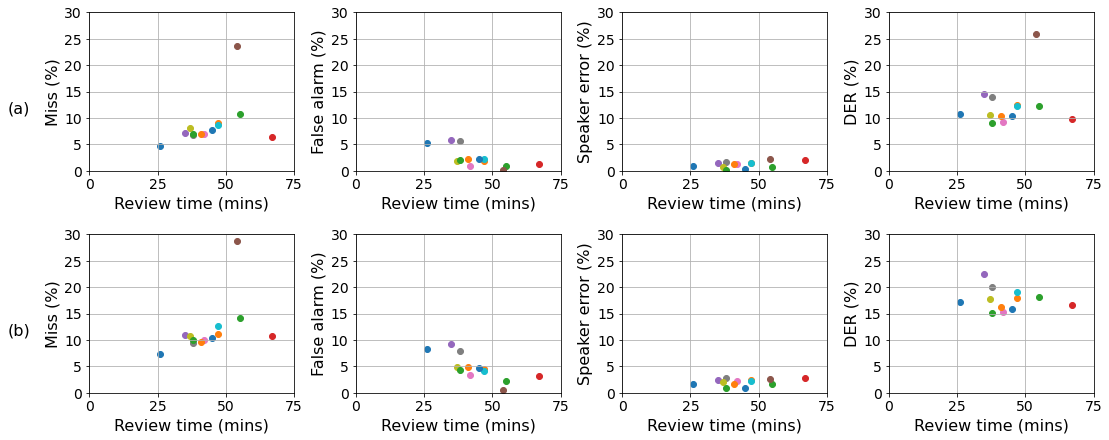

In [147]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 30])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(7)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 11, "(a)",fontsize=16)
axes[1][0].text(-30, 11, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

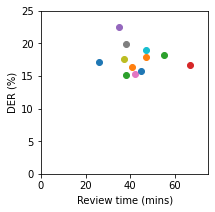

In [148]:
fig, ax = plt.subplots(figsize=(3, 3))

for i in range(len(review_times)):
    ax.scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
ax.set_xlabel("Review time (mins)")
ax.set_ylabel("DER (%)")
ax.set_xlim([0, 75])
ax.set_ylim([0, 25])

plt.show()

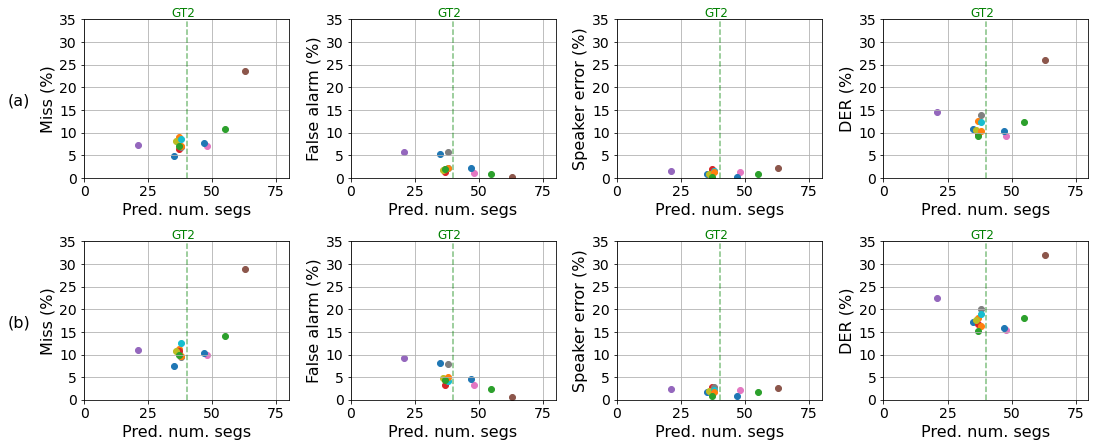

In [150]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(40, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(34, 35.5, "GT2", color="green", fontsize=12)

# System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_predNumSegs_GT2.png")

plt.show()

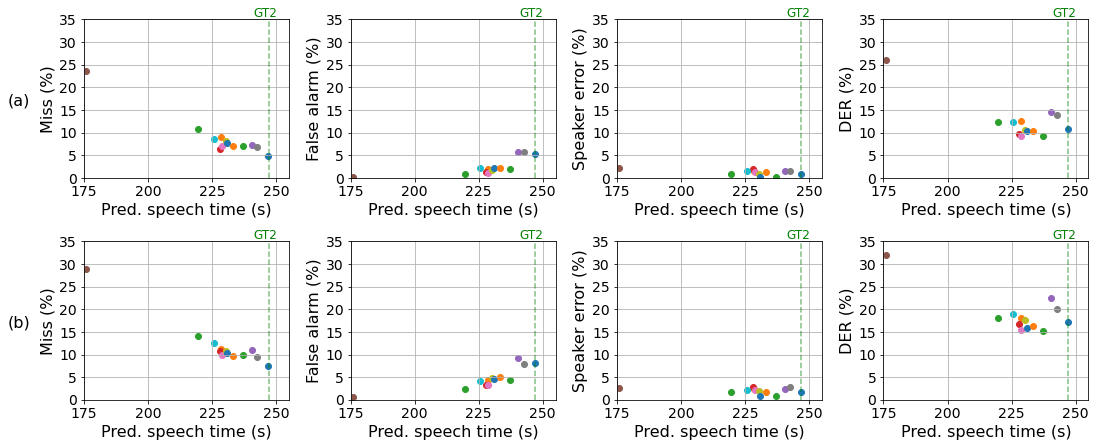

In [151]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(247, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(241, 35.5, "GT2", color="green", fontsize=12)
    
# # System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 255])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(145, 16, "(a)",fontsize=16)
axes[1][0].text(145, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_predSpchTime_GT2.png")

plt.show()

In [152]:
ders_250 = [dfs[i].iloc[0]["DER (%)"] for i in range(len(review_times))]
ders_0 = [dfs[i].iloc[-1]["DER (%)"] for i in range(len(review_times))]
print("Mean DER with 250 ms collars for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250), np.std(ders_250)))
print("Mean DER with no collar for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0), np.std(ders_0)))

Mean DER with 250 ms collars for all reviewers is 12.44% and standard deviation is 4.23%
Mean DER with no collar for all reviewers is 18.75% and standard deviation is 4.28%


In [153]:
ders_250_top = sorted(ders_250)[:-2]
ders_0_top = sorted(ders_0)[:-2]
print("Mean DER with 250 ms collars for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250_top), np.std(ders_250_top)))
print("Mean DER with no collar for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0_top), np.std(ders_0_top)))

Mean DER with 250 ms collars for top reviewers excluding two outliers is 11.02% and standard deviation is 1.46%
Mean DER with no collar for top reviewers excluding two outliers is 17.20% and standard deviation is 1.45%


In [154]:
print(ders_0_top)
print(ders_250_top)

[15.16, 15.33, 15.81, 16.31, 16.68, 17.18, 17.67, 17.97, 18.15, 19.0, 19.95]
[9.13, 9.16, 9.76, 10.36, 10.38, 10.63, 10.8, 12.26, 12.35, 12.48, 13.93]


In [155]:
# Ignoring two outliers
ders = [[], [], [], [], [], []]
for i in range(len(review_times)):
    for j in range(6):
        ders[j].append([dfs[i].iloc[j]["DER (%)"]])
    
ders_means = []
ders_stds = []
for j in range(6):
    ders_means.append(np.mean(sorted(ders[j])[:-2]))
    ders_stds.append(np.std(sorted(ders[j])[:-2]))
    
print("DER means for decreasing collar sizes: {}".format([round(ders_means[i], 2) for i in range(6)]))
print("DER stds for decreasing collar sizes: {}".format([round(ders_stds[i], 2) for i in range(6)]))

DER means for decreasing collar sizes: [11.02, 11.97, 13.06, 14.26, 15.62, 17.2]
DER stds for decreasing collar sizes: [1.46, 1.46, 1.46, 1.44, 1.44, 1.45]


### GT3

In [23]:
dfs = []
counts = []
agg_times = []
num_spkrs_pred = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            txt += "SPEAKER ES2008a 1 {} {:.3f} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    num_spkrs_pred.append(len(sorted(set(pred_spkrs))))
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 1: 35
Total speech time predicted by reviewer 1: 246.92
Comb speech time predicted by reviewer 1: 240.24
Percent overlapping speech predicted by reviewer 1: 2.78%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 2: 37
Total speech time predicted by reviewer 2: 228.53
Comb speech time predicted by reviewer 2: 220.72
Percent overlapping speech predicted by reviewer 2: 3.54%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1', '2', '3', '4', '5']
Number of speaker segments predicted by reviewer 3: 55
Total speech time predicted by reviewer 3: 219.58
Comb speech time predicted by reviewer 3: 218.33
Percent overlapping speech predicted by reviewer 3: 0.57%
Running md-eval-v21.pl scripts complete

Check set of predicted speake

In [24]:
counts

[35, 37, 55, 37, 21, 63, 48, 38, 36, 38, 47, 38, 37]

In [25]:
num_spkrs_pred

[4, 4, 5, 6, 4, 5, 4, 4, 5, 4, 4, 4, 4]

In [26]:
for i in range(len(review_times)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.80,6.94,0.75,9.48
1,200,2.06,7.71,0.87,10.64
2,150,2.40,8.47,1.01,11.88
3,100,2.84,9.25,1.17,13.27
4,50,3.29,10.10,1.37,14.75
5,0,3.77,11.07,1.59,16.44


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.24,3.17,1.28,10.69
1,200,6.41,3.80,1.42,11.63
2,150,6.65,4.48,1.55,12.68
3,100,6.93,5.18,1.70,13.81
4,50,7.21,5.90,1.91,15.02
5,0,7.52,6.83,2.12,16.48


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.97,1.27,0.61,9.84
1,200,8.22,1.62,0.78,10.63
2,150,8.65,2.04,0.95,11.64
3,100,9.13,2.54,1.13,12.82
4,50,9.66,3.15,1.31,14.13
5,0,10.22,4.02,1.53,15.77


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.66,2.31,1.71,7.68
1,200,3.98,2.71,1.90,8.59
2,150,4.45,3.20,2.11,9.76
3,100,5.10,3.77,2.36,11.23
4,50,5.90,4.40,2.57,12.88
5,0,6.75,5.13,2.81,14.69


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.24,9.06,1.22,15.52
1,200,5.78,9.88,1.40,17.05
2,150,6.44,10.71,1.60,18.74
3,100,7.16,11.53,1.79,20.47
4,50,7.88,12.31,2.01,22.20
5,0,8.60,13.12,2.23,23.96


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,21.38,0.34,1.67,23.39
1,200,21.66,0.40,1.88,23.95
2,150,22.20,0.50,2.09,24.79
3,100,22.90,0.64,2.29,25.83
4,50,23.81,0.85,2.48,27.15
5,0,24.80,1.22,2.71,28.73


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.83,1.92,1.44,7.20
1,200,4.11,2.60,1.63,8.34
2,150,4.53,3.32,1.79,9.64
3,100,5.10,4.07,1.95,11.12
4,50,5.69,4.87,2.16,12.72
5,0,6.37,5.74,2.39,14.50


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.99,7.00,1.10,12.09
1,200,4.25,7.54,1.26,13.05
2,150,4.55,8.13,1.47,14.15
3,100,4.93,8.81,1.72,15.47
4,50,5.31,9.61,2.03,16.96
5,0,5.78,10.53,2.36,18.66


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,4.57,3.40,0.48,8.46
1,200,4.93,4.19,0.63,9.75
2,150,5.38,5.02,0.78,11.18
3,100,5.94,5.80,1.00,12.74
4,50,6.58,6.57,1.25,14.40
5,0,7.33,7.40,1.53,16.26


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.84,3.60,0.94,10.37
1,200,6.19,4.11,1.00,11.30
2,150,6.71,4.64,1.10,12.45
3,100,7.42,5.19,1.23,13.83
4,50,8.16,5.75,1.42,15.33
5,0,8.97,6.41,1.62,16.99


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,4.64,3.26,0.37,8.26
1,200,4.89,3.91,0.41,9.21
2,150,5.24,4.59,0.47,10.29
3,100,5.66,5.31,0.61,11.58
4,50,6.19,6.14,0.77,13.10
5,0,6.79,7.09,0.95,14.83


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.80,3.10,0.81,7.71
1,200,4.05,3.66,0.95,8.66
2,150,4.35,4.31,1.09,9.74
3,100,4.70,5.03,1.27,10.99
4,50,5.07,5.88,1.51,12.46
5,0,5.54,6.91,1.74,14.19


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.95,2.72,0.00,6.67
1,200,4.24,3.33,0.00,7.57
2,150,4.59,3.98,0.03,8.60
3,100,5.05,4.67,0.08,9.81
4,50,5.50,5.40,0.22,11.13
5,0,5.98,6.43,0.39,12.80


In [96]:
# Copying diarization system data from dataOdyssey2022_10.ipynb

dfs_sys = []
cols = ["Collar (ms)", "MISSED (%)", "FALARM (%)", "ERROR (%)", "DER (%)"]

# Order is [CNN+LSTM, ResNet101, BDII, KF ensemble]
counts_sys = [77, 49, 42, 48]
agg_times_sys = [218.5, 240.0, 230.25, 228.0]
data1 = [[250, 10.85, 5.19, 2.46, 18.51],
        [200, 11.25, 5.74, 2.53, 19.52],
        [150, 11.74, 6.40, 2.62, 20.76],
        [100, 12.27, 7.11, 2.72, 22.09],
        [50, 12.89, 7.80, 2.84, 23.52],
        [0, 13.49, 8.55, 2.96, 25.00]]

data2 = [[250, 5.66, 6.25, 0.94, 12.85],
        [200, 5.83, 7.29, 1.05, 14.17],
        [150, 6.12, 8.33, 1.21, 15.67],
        [100, 6.48, 9.43, 1.37, 17.28],
        [50, 6.87, 10.53, 1.57, 18.97],
        [0, 7.32, 11.62, 1.74, 20.68]]

data3 = [[250, 7.15, 5.27, 0.96, 13.39],
        [200, 7.48, 6.15, 1.11, 14.75],
        [150, 7.91, 7.00, 1.32, 16.23],
        [100, 8.43, 7.91, 1.55, 17.89],
        [50, 8.99, 8.79, 1.85, 19.62],
        [0, 9.60, 9.66, 2.13, 21.38]]

data4 = [[250, 7.23, 2.64, 0.36, 10.23],
        [200, 7.92, 3.22, 0.45, 11.59],
        [150, 8.75, 3.85, 0.58, 13.18],
        [100, 9.71, 4.49, 0.75, 14.95],
        [50, 10.77, 5.14, 0.95, 16.85],
        [0, 11.79, 5.82, 1.17, 18.78]]

for dat in [data1, data2, data3, data4]:
    dfs_sys.append(pd.DataFrame(dat, columns=cols))

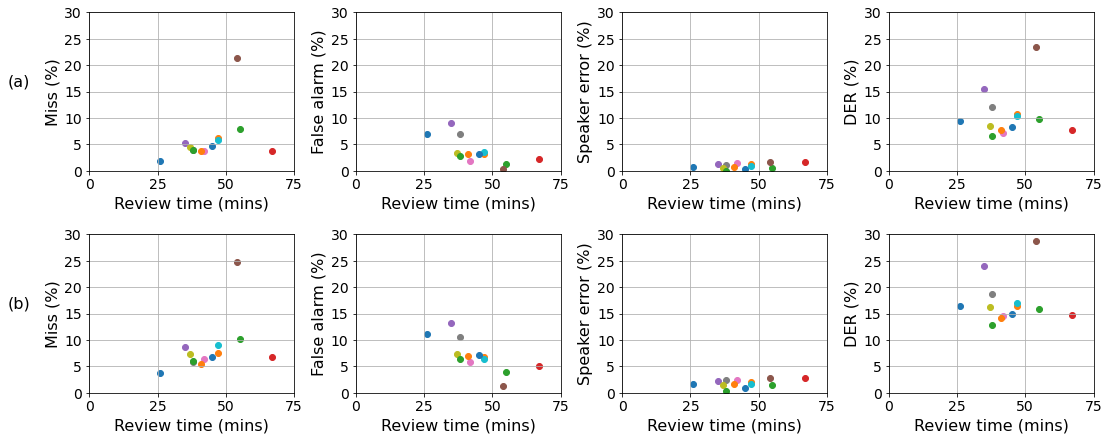

In [97]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 30])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(7)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_reviewTime_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

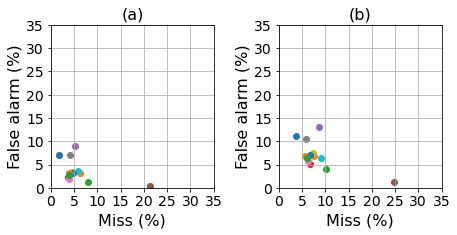

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 35])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([5*i for i in range(8)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a)", fontsize=16)
axes[1].set_title("(b)", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_missvfalarm_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

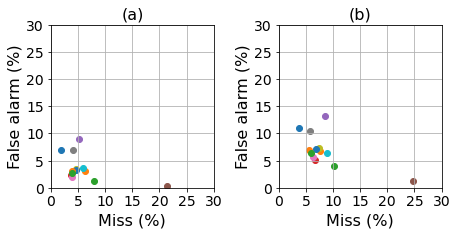

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 30])
    axes[i].set_ylim([0, 30])
    axes[i].set_xticks([5*i for i in range(7)])
    axes[i].set_yticks([5*i for i in range(7)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a)", fontsize=16)
axes[1].set_title("(b)", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.savefig("../../HumanReviews/graphs/220510_Graph_missvfalarm_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

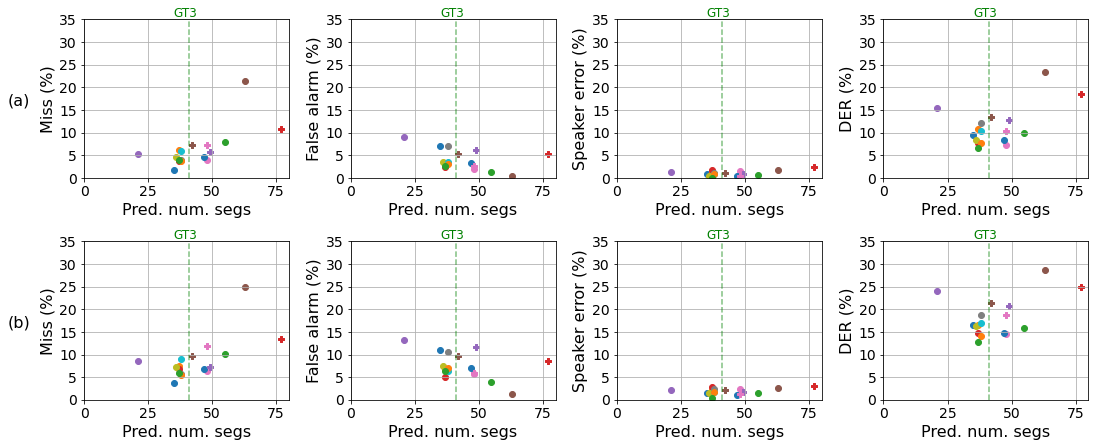

In [100]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(41, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(35, 35.5, "GT3", color="green", fontsize=12)

#System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=30)
    axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
    axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
    axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
    axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
    axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
    axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220510_Graph_predNumSegs_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

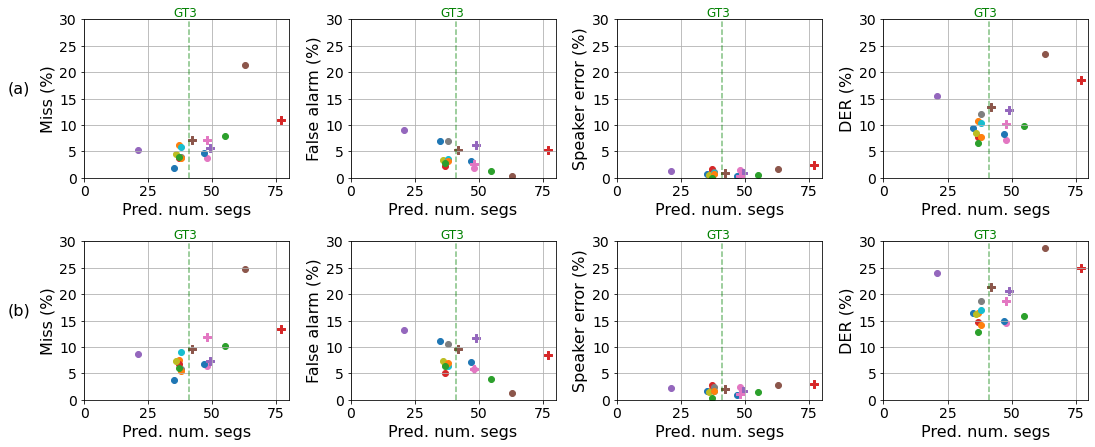

In [101]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(41, 0, 30, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(35, 30.5, "GT3", color="green", fontsize=12)

#System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=60)
    axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P", s=60)
    axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P", s=60)
    axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P", s=60)
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P", s=60)
    axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P", s=60)
    axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P", s=60)
    axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P", s=60)
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 30])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(7)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220510_Graph_predNumSegs_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

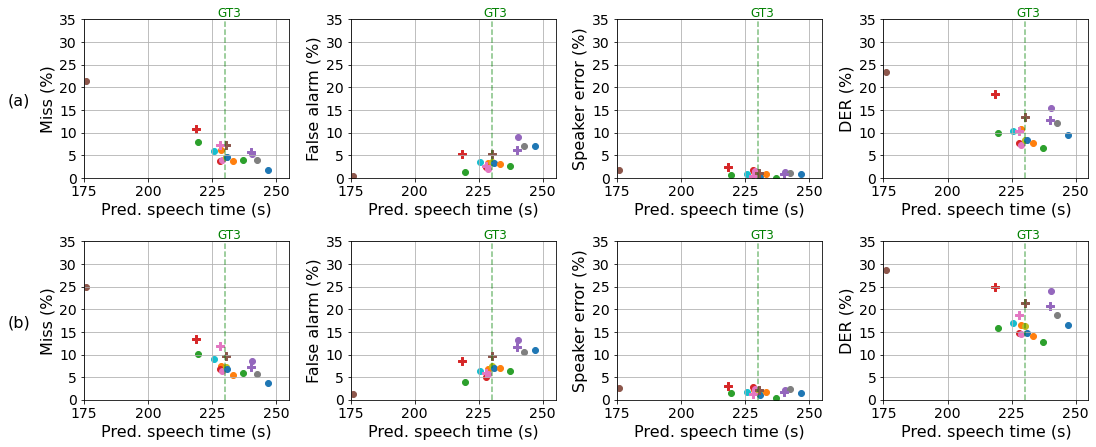

In [102]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(230.12, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(227, 35.5, "GT3", color="green", fontsize=12)
    
# System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=60)
    axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P", s=60)
    axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P", s=60)
    axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P", s=60)
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P", s=60)
    axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P", s=60)
    axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P", s=60)
    axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P", s=60)
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 255])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(145, 16, "(a)",fontsize=16)
axes[1][0].text(145, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_predSpchTime_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

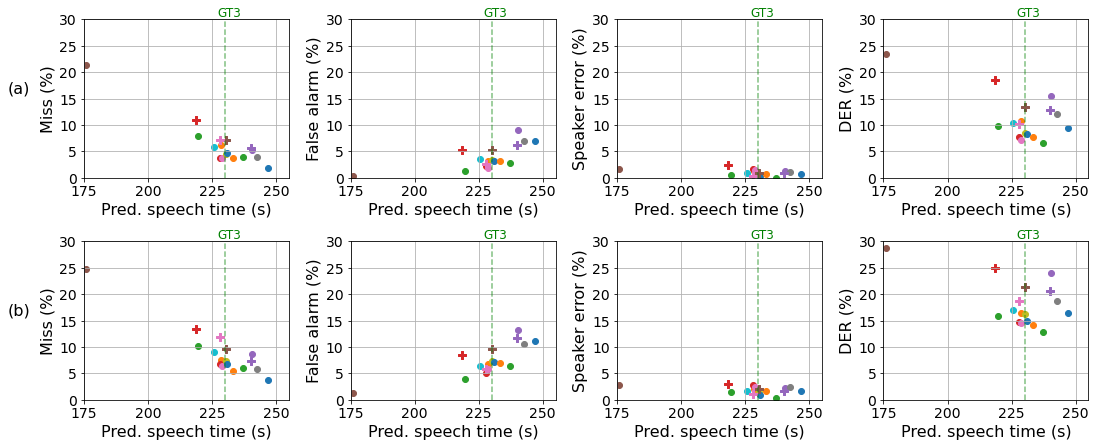

In [103]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(230.12, 0, 30, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(227, 30.5, "GT3", color="green", fontsize=12)
    
# System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=60)
    axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P", s=60)
    axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P", s=60)
    axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P", s=60)
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P", s=60)
    axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P", s=60)
    axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P", s=60)
    axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P", s=60)
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 255])
        axes[i][j].set_ylim([0, 30])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(7)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(145, 16, "(a)",fontsize=16)
axes[1][0].text(145, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220510_Graph_predSpchTime_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

In [104]:
ders_250 = [dfs[i].iloc[0]["DER (%)"] for i in range(len(review_times))]
ders_0 = [dfs[i].iloc[-1]["DER (%)"] for i in range(len(review_times))]
print("Mean DER with 250 ms collars for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250), np.std(ders_250)))
print("Mean DER with no collar for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0), np.std(ders_0)))

Mean DER with 250 ms collars for all reviewers is 10.57% and standard deviation is 4.35%
Mean DER with no collar for all reviewers is 17.25% and standard deviation is 4.23%


In [105]:
ders_250_top = sorted(ders_250)[:-2]
ders_0_top = sorted(ders_0)[:-2]
print("Mean DER with 250 ms collars for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250_top), np.std(ders_250_top)))
print("Mean DER with no collar for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0_top), np.std(ders_0_top)))

Mean DER with 250 ms collars for top reviewers excluding two outliers is 8.95% and standard deviation is 1.60%
Mean DER with no collar for top reviewers excluding two outliers is 15.60% and standard deviation is 1.53%


In [106]:
print(ders_0_top)
print(ders_250_top)

[12.8, 14.19, 14.5, 14.69, 14.83, 15.77, 16.26, 16.44, 16.48, 16.99, 18.66]
[6.67, 7.2, 7.68, 7.71, 8.26, 8.46, 9.48, 9.84, 10.37, 10.69, 12.09]


In [107]:
# Ignoring two outliers
ders = [[], [], [], [], [], []]
for i in range(len(review_times)):
    for j in range(6):
        ders[j].append([dfs[i].iloc[j]["DER (%)"]])
    
ders_means = []
ders_stds = []
for j in range(6):
    ders_means.append(np.mean(sorted(ders[j])[:-2]))
    ders_stds.append(np.std(sorted(ders[j])[:-2]))
    
print("DER means for decreasing collar sizes: {}".format([round(ders_means[i], 2) for i in range(6)]))
print("DER stds for decreasing collar sizes: {}".format([round(ders_stds[i], 2) for i in range(6)]))

DER means for decreasing collar sizes: [8.95, 9.94, 11.09, 12.42, 13.9, 15.6]
DER stds for decreasing collar sizes: [1.6, 1.58, 1.57, 1.56, 1.55, 1.53]


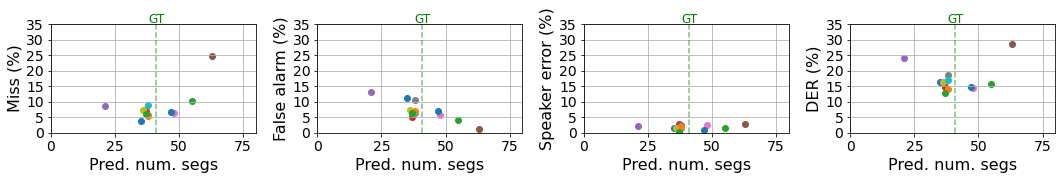

In [16]:
# Simplified version without systems points, only referring to GT and no collar
# For UK Speech 2022 abstract
nPlots = 4
fig, axes = plt.subplots(1, nPlots, figsize=(18, 2))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
# for i in range(len(counts)):
#     axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
#     axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
#     axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
#     axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
#for i in range(2):
for j in range(4):
    axes[j].axvline(41, 0, 35, color="green", linestyle="--", alpha=0.5)
    axes[j].text(38, 35.5, "GT", color="green", fontsize=12)

#System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=30)
#     axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
#for i in range(2):
for j in range(nPlots):
    axes[j].set_xlabel("Pred. num. segs", fontsize=16)
    axes[j].set_ylabel(cols[j], fontsize=16)
    axes[j].set_xlim([0, 80])
    axes[j].set_ylim([0, 35])
    axes[j].set_xticks([25*i for i in range(4)])
    axes[j].set_yticks([5*i for i in range(8)])
    axes[j].grid()
    for label in (axes[j].get_xticklabels() + axes[j].get_yticklabels()):
        label.set_fontsize(14)

# axes[0][0].text(-30, 16, "(a)",fontsize=16)
# axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220709_Graph_predNumSegs_GT3_NoSystems.pdf", bbox_inches='tight', dpi=1200)

plt.show()

In [29]:
# pyannote.audio data

dfs_sys = []
cols = ["Collar (ms)", "MISSED (%)", "FALARM (%)", "ERROR (%)", "DER (%)"]

# Order is [CNN+LSTM, ResNet101, BDII, KF ensemble]
counts_sys = [40, 32]
agg_times_sys = [221.31, 242.00]
data1 = [[250, 4.64, 0.53, 1.15, 6.33],
        [200, 4.92, 0.73, 1.23, 6.88],
        [150, 5.30, 0.92, 1.37, 7.59],
        [100, 5.72, 1.14, 1.59, 8.45],
        [50, 6.21, 1.58, 1.84, 9.63],
        [0, 6.83, 2.31, 2.09, 11.23]]

data2 = [[250, 4.20, 6.13, 3.92, 14.25],
        [200, 4.48, 7.09, 4.23, 15.80],
        [150, 4.84, 8.07, 4.57, 17.48],
        [100, 5.27, 9.01, 4.94, 19.22],
        [50, 5.70, 9.96, 5.35, 21.01],
        [0, 6.14, 10.99, 5.73, 22.86]]

for dat in [data1, data2]:
    dfs_sys.append(pd.DataFrame(dat, columns=cols))

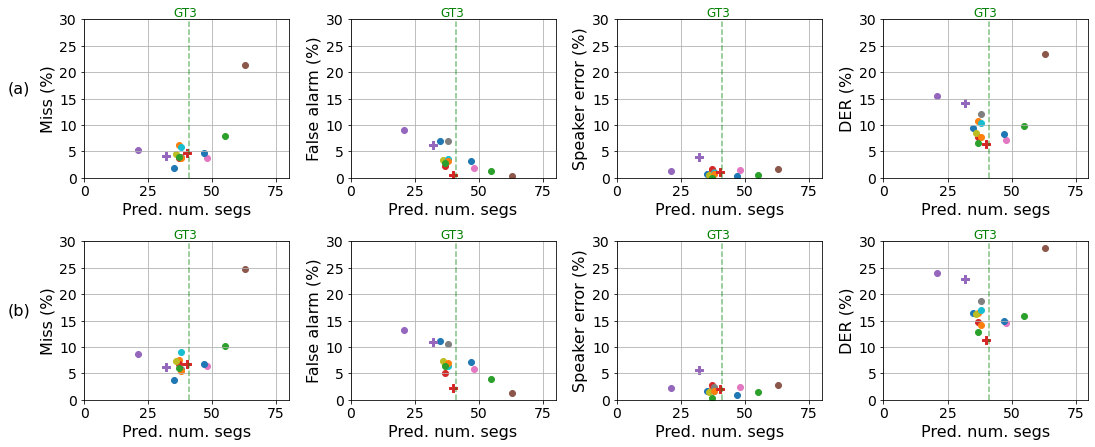

In [30]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(41, 0, 30, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(35, 30.5, "GT3", color="green", fontsize=12)

#System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=60)
    axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P", s=60)
    axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P", s=60)
    axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P", s=60)
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P", s=60)
    axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P", s=60)
    axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P", s=60)
    axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P", s=60)
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 30])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(7)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220811_Graph_predNumSegs_GT3_pyannote.pdf", bbox_inches='tight', dpi=1200)

plt.show()

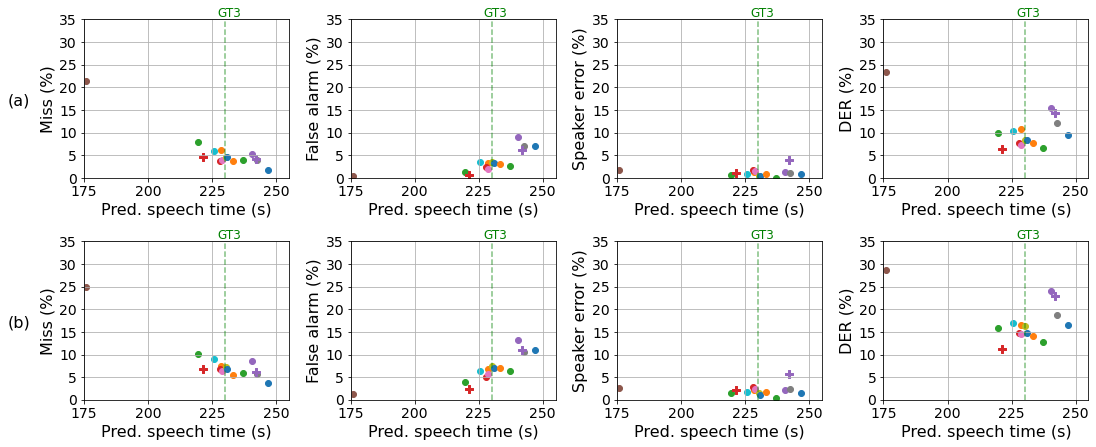

In [31]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(230.12, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(227, 35.5, "GT3", color="green", fontsize=12)
    
# System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=60)
    axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P", s=60)
    axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P", s=60)
    axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P", s=60)
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P", s=60)
    axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P", s=60)
    axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P", s=60)
    axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P", s=60)
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 255])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(145, 16, "(a)",fontsize=16)
axes[1][0].text(145, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220811_Graph_predSpchTime_GT3_pyannote.pdf", bbox_inches='tight', dpi=1200)

plt.show()

### GT4

In [167]:
dfs = []
counts = []
agg_times = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            txt += "SPEAKER ES2008a 1 {} {:.3f} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "testingModSpecLSTM/rttm_gt4/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 1: 35
Total speech time predicted by reviewer 1: 246.92
Comb speech time predicted by reviewer 1: 240.24
Percent overlapping speech predicted by reviewer 1: 2.78%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 2: 37
Total speech time predicted by reviewer 2: 228.53
Comb speech time predicted by reviewer 2: 220.72
Percent overlapping speech predicted by reviewer 2: 3.54%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1', '2', '3', '4', '5']
Number of speaker segments predicted by reviewer 3: 55
Total speech time predicted by reviewer 3: 219.58
Comb speech time predicted by reviewer 3: 218.33
Percent overlapping speech predicted by reviewer 3: 0.57%
Running md-eval-v21.pl scripts complete

Check set of predicted speake

Running md-eval-v21.pl scripts complete



In [168]:
for i in range(len(review_times)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.31,6.01,0.72,10.03
1,200,3.71,6.77,0.85,11.33
2,150,4.15,7.52,1.01,12.69
3,100,4.70,8.28,1.18,14.17
4,50,5.27,9.10,1.37,15.74
5,0,5.89,10.05,1.60,17.54


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.98,2.95,1.51,12.43
1,200,8.36,3.59,1.58,13.53
2,150,8.80,4.26,1.65,14.71
3,100,9.25,4.94,1.74,15.93
4,50,9.67,5.64,1.88,17.20
5,0,10.11,6.52,2.07,18.70


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,9.59,1.05,0.61,11.25
1,200,10.00,1.41,0.78,12.19
2,150,10.57,1.82,0.94,13.33
3,100,11.22,2.30,1.12,14.64
4,50,11.92,2.89,1.28,16.09
5,0,12.64,3.70,1.50,17.84


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.23,2.15,1.93,9.31
1,200,5.75,2.54,2.11,10.40
2,150,6.40,2.98,2.33,11.71
3,100,7.21,3.51,2.58,13.30
4,50,8.19,4.08,2.76,15.04
5,0,9.24,4.75,2.96,16.95


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.15,8.72,1.36,17.23
1,200,7.77,9.48,1.58,18.84
2,150,8.51,10.24,1.81,20.57
3,100,9.31,10.99,2.03,22.33
4,50,10.11,11.69,2.27,24.07
5,0,10.94,12.40,2.51,25.84


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,22.31,0.34,1.90,24.55
1,200,22.87,0.40,2.04,25.32
2,150,23.66,0.50,2.19,26.34
3,100,24.60,0.63,2.32,27.55
4,50,25.74,0.83,2.46,29.04
5,0,26.98,1.17,2.64,30.80


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.35,1.66,1.08,8.08
1,200,5.85,2.32,1.25,9.42
2,150,6.49,3.04,1.40,10.93
3,100,7.28,3.79,1.56,12.63
4,50,8.06,4.56,1.78,14.40
5,0,8.91,5.38,2.05,16.34


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.71,6.66,1.42,13.80
1,200,6.11,7.15,1.58,14.84
2,150,6.54,7.67,1.79,16.00
3,100,7.05,8.27,2.04,17.36
4,50,7.55,8.98,2.34,18.88
5,0,8.13,9.83,2.68,20.65


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.14,3.42,0.48,10.05
1,200,6.76,4.18,0.63,11.57
2,150,7.44,4.97,0.78,13.19
3,100,8.23,5.71,0.98,14.92
4,50,9.08,6.43,1.22,16.73
5,0,10.04,7.18,1.49,18.71


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.07,3.04,0.89,10.99
1,200,7.69,3.56,0.95,12.20
2,150,8.43,4.13,1.05,13.61
3,100,9.36,4.69,1.15,15.20
4,50,10.32,5.26,1.28,16.86
5,0,11.32,5.91,1.46,18.68


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.37,2.69,0.37,9.43
1,200,6.77,3.37,0.41,10.55
2,150,7.26,4.06,0.46,11.78
3,100,7.81,4.80,0.60,13.22
4,50,8.47,5.64,0.75,14.86
5,0,9.20,6.58,0.92,16.70


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.30,2.94,1.12,9.36
1,200,5.75,3.49,1.23,10.47
2,150,6.27,4.11,1.33,11.71
3,100,6.84,4.79,1.47,13.11
4,50,7.45,5.59,1.65,14.69
5,0,8.15,6.56,1.84,16.55


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.57,2.54,0.09,8.20
1,200,6.05,3.13,0.14,9.32
2,150,6.57,3.76,0.20,10.54
3,100,7.24,4.42,0.26,11.92
4,50,7.89,5.10,0.40,13.39
5,0,8.54,6.05,0.57,15.15


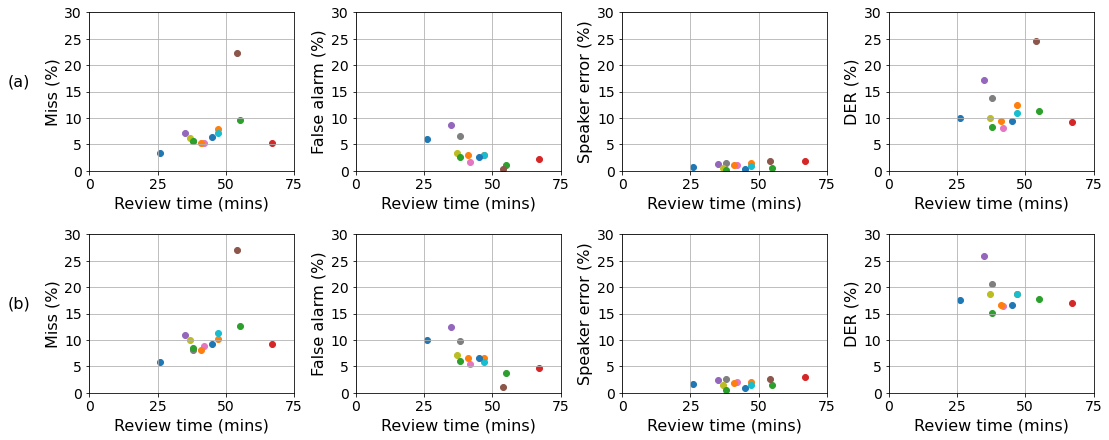

In [170]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 30])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(7)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

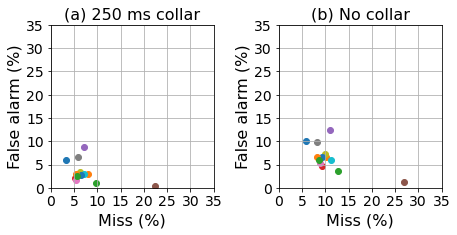

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 35])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([5*i for i in range(8)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a) 250 ms collar", fontsize=16)
axes[1].set_title("(b) No collar", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.show()

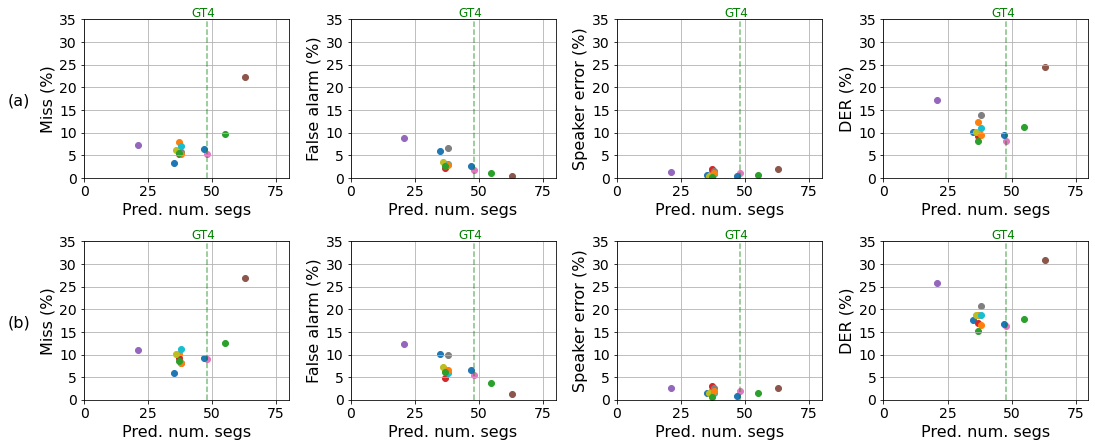

In [172]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(48, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(42, 35.5, "GT4", color="green", fontsize=12)

# System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_predNumSegs_GT4.png")

plt.show()

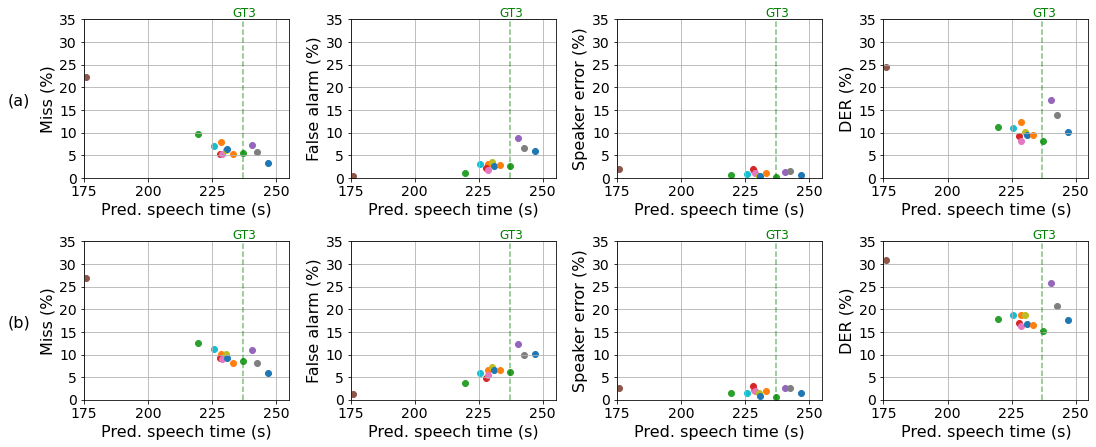

In [173]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(237.048, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(233, 35.5, "GT4", color="green", fontsize=12)
    
# # System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 255])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(145, 16, "(a)",fontsize=16)
axes[1][0].text(145, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220412_Graph_predSpchTime_GT4.png")

plt.show()

In [174]:
ders_250 = [dfs[i].iloc[0]["DER (%)"] for i in range(len(review_times))]
ders_0 = [dfs[i].iloc[-1]["DER (%)"] for i in range(len(review_times))]
print("Mean DER with 250 ms collars for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250), np.std(ders_250)))
print("Mean DER with no collar for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0), np.std(ders_0)))

Mean DER with 250 ms collars for all reviewers is 11.90% and standard deviation is 4.37%
Mean DER with no collar for all reviewers is 19.27% and standard deviation is 4.20%


In [175]:
ders_250_top = sorted(ders_250)[:-2]
ders_0_top = sorted(ders_0)[:-2]
print("Mean DER with 250 ms collars for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250_top), np.std(ders_250_top)))
print("Mean DER with no collar for top reviewers excluding two outliers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0_top), np.std(ders_0_top)))

Mean DER with 250 ms collars for top reviewers excluding two outliers is 10.27% and standard deviation is 1.66%
Mean DER with no collar for top reviewers excluding two outliers is 17.62% and standard deviation is 1.44%


In [176]:
print(ders_0_top)
print(ders_250_top)

[15.15, 16.34, 16.55, 16.7, 16.95, 17.54, 17.84, 18.68, 18.7, 18.71, 20.65]
[8.08, 8.2, 9.31, 9.36, 9.43, 10.03, 10.05, 10.99, 11.25, 12.43, 13.8]


In [177]:
# Ignoring two outliers
ders = [[], [], [], [], [], []]
for i in range(len(review_times)):
    for j in range(6):
        ders[j].append([dfs[i].iloc[j]["DER (%)"]])
    
ders_means = []
ders_stds = []
for j in range(6):
    ders_means.append(np.mean(sorted(ders[j])[:-2]))
    ders_stds.append(np.std(sorted(ders[j])[:-2]))
    
print("DER means for decreasing collar sizes: {}".format([round(ders_means[i], 2) for i in range(6)]))
print("DER stds for decreasing collar sizes: {}".format([round(ders_stds[i], 2) for i in range(6)]))

DER means for decreasing collar sizes: [10.27, 11.44, 12.75, 14.22, 15.81, 17.62]
DER stds for decreasing collar sizes: [1.66, 1.61, 1.57, 1.52, 1.48, 1.44]


In [25]:
data = []
for i in range(len(review_times)):
    data.append([dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"], dfs[i].iloc[-1]["ERROR (%)"], dfs[i].iloc[-1]["DER (%)"]])
data

[[7.359999999999999, 8.200000000000001, 1.63, 17.18],
 [11.14, 4.4799999999999995, 2.35, 17.97],
 [14.14, 2.29, 1.72, 18.15],
 [10.72, 3.17, 2.79, 16.68],
 [10.92, 9.139999999999999, 2.4899999999999998, 22.55],
 [28.78, 0.6, 2.56, 31.96],
 [9.9, 3.29, 2.15, 15.33],
 [9.36, 7.82, 2.77, 19.95],
 [10.79, 4.84, 2.0500000000000003, 17.67],
 [12.64, 4.21, 2.16, 19.0],
 [10.33, 4.6, 0.88, 15.81],
 [9.65, 4.93, 1.7399999999999998, 16.31],
 [9.950000000000001, 4.35, 0.86, 15.16]]

In [26]:
pd.DataFrame(data, columns=cols).index

RangeIndex(start=0, stop=13, step=1)

In [27]:
df = df.melt(id_vars='index')
sns.barplot(x = 'variable', y = 'value' , data = df, hue = 'index' )


KeyError: 'index'

In [50]:
df_errors

NameError: name 'df_errors' is not defined

In [51]:
df_errors["label"] = [i for i in range(len(review_times))]

NameError: name 'df_errors' is not defined

In [52]:
df_errors.index

NameError: name 'df_errors' is not defined

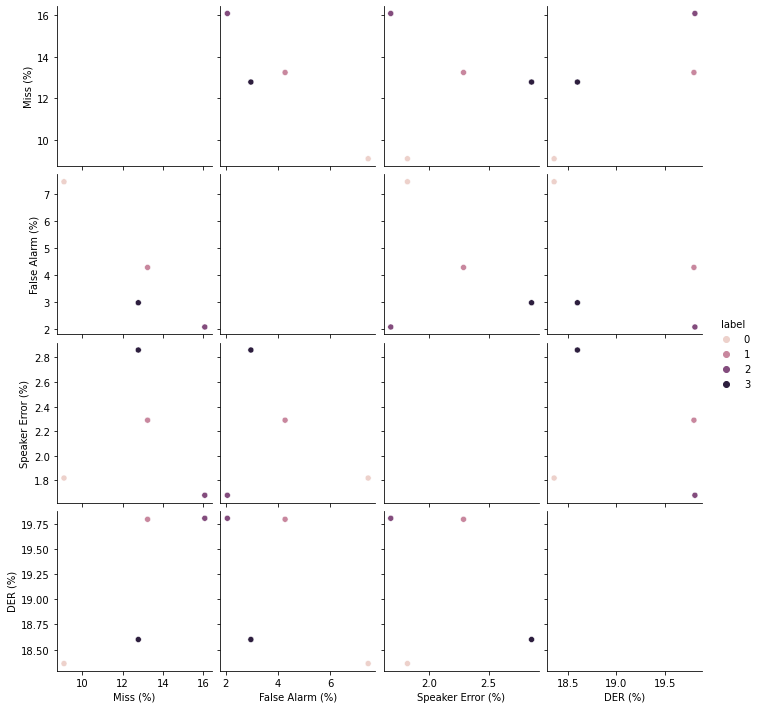

In [113]:
#df_errors = pd.DataFrame(data, columns=cols, index=[i for i in range(len(review_times))])
#display(df_errors)
#df_errors = df_errors.melt(id_vars='index')
sns.pairplot(df_errors, hue="label")

## SAD Reviews

In [5]:
# Review times manually recorded in minutes
review_times = [9, 21, 16, 17, 24, 16, 26, 12, 14, 34]

In [6]:
rpath = "../../HumanReviews/Reviews_SAD/"
lst_reviews = [file[:-4] for file in os.listdir(rpath)]
lst_reviews = natsorted(lst_reviews)
lst_reviews

['SAD_Reviewer1_1',
 'SAD_Reviewer1_2',
 'SAD_Reviewer1_3',
 'SAD_Reviewer1_4',
 'SAD_Reviewer1_5',
 'SAD_Reviewer1_6',
 'SAD_Reviewer1_7',
 'SAD_Reviewer1_8',
 'SAD_Reviewer1_9',
 'SAD_Reviewer1_10']

In [7]:
dfs = []
counts = []
agg_times = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
#             if index == 2:
#                 print(lineItems)
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            if "/" in lineItems[2]:
                lineItems[2] = lineItems[2].split("/")[0]
            txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1f', '2f', '3m', '4f']
Number of speaker segments predicted by reviewer 1: 37
Total speech time predicted by reviewer 1: 226.90
Comb speech time predicted by reviewer 1: 220.08
Percent overlapping speech predicted by reviewer 1: 3.10%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1f', '2f', '3m', '4f']
Number of speaker segments predicted by reviewer 2: 42
Total speech time predicted by reviewer 2: 227.09
Comb speech time predicted by reviewer 2: 220.00
Percent overlapping speech predicted by reviewer 2: 3.22%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1F', '2F', '3F', '4M']
Number of speaker segments predicted by reviewer 3: 39
Total speech time predicted by reviewer 3: 227.88
Comb speech time predicted by reviewer 3: 220.32
Percent overlapping speech predicted by reviewer 3: 3.43%
Running md-eval-v21.pl scripts complete

Check set of predicted

Running md-eval-v21.pl scripts complete



In [14]:
# Copying diarization system data from further down this notebook

dfs_sys = []
cols = ["Collar (ms)", "MISSED (%)", "FALARM (%)", "ERROR (%)", "DER (%)"]

# Order is [ResNet101, BDII]
counts_sys = [39, 43, 35]
agg_times_sys = [220.00, 218.00, 223.00]
data1 = [[250, 2.31, 0.0, 1.02, 3.33],
        [200, 2.58, 0.0, 1.15, 3.73],
        [150, 2.94, 0.0, 1.34, 4.28],
        [100, 3.37, 0.0, 1.62, 5.00],
        [50, 3.81, 0.0, 1.95, 5.77],
        [0, 4.26, 0.0, 2.29, 6.55]]

data2 = [[250, 2.31, 0.0, 3.29, 5.59],
        [200, 2.58, 0.0, 3.47, 6.05],
        [150, 2.94, 0.0, 3.72, 6.66],
        [100, 3.37, 0.0, 4.06, 7.43],
        [50, 3.81, 0.0, 4.46, 8.27],
        [0, 4.26, 0.0, 4.86, 9.12]]

data3 = [[250, 1.75, 0.0, 1.09, 2.84],
        [200, 1.90, 0.0, 1.25, 3.14],
        [150, 2.13, 0.0, 1.45, 3.58],
        [100, 2.40, 0.0, 1.69, 4.09],
        [50, 2.69, 0.0, 1.98, 4.67],
        [0, 2.97, 0.0, 2.28, 5.25]]

for dat in [data1, data2, data3]:
    dfs_sys.append(pd.DataFrame(dat, columns=cols))

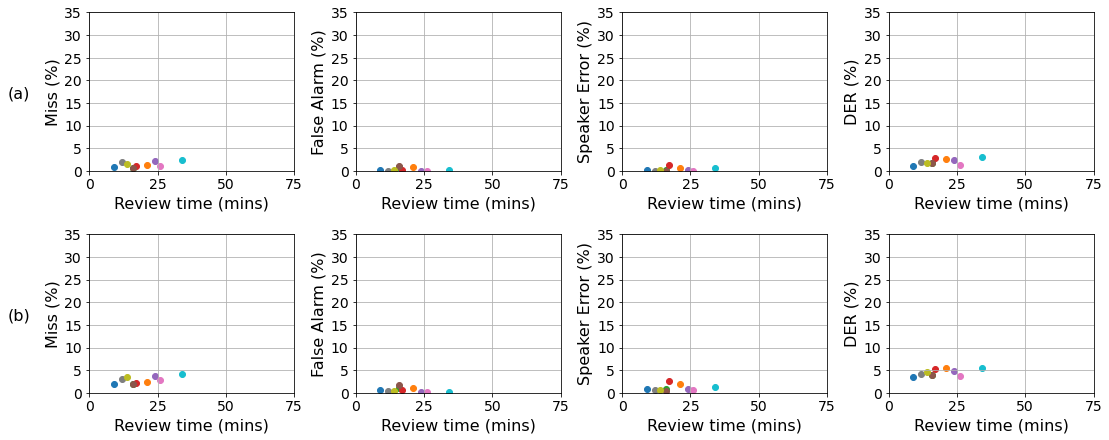

In [10]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False Alarm (%)", "Speaker Error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220429_Graph_SAD_predSpchTime_GT3.pdf", bbox_inches="tight", dpi=1200)

plt.show()

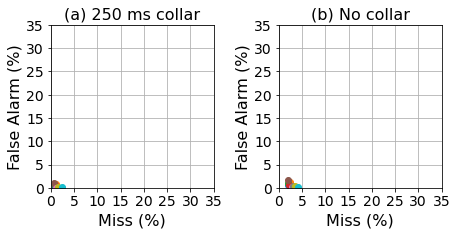

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False Alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 35])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([5*i for i in range(8)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a) 250 ms collar", fontsize=16)
axes[1].set_title("(b) No collar", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.show()

In [11]:
ders_250 = [dfs[i].iloc[0]["DER (%)"] for i in range(len(review_times))]
ders_0 = [dfs[i].iloc[-1]["DER (%)"] for i in range(len(review_times))]
print("Mean DER with 250 ms collars for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250), np.std(ders_250)))
print("Mean DER with no collar for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0), np.std(ders_0)))

Mean DER with 250 ms collars for all reviewers is 2.03% and standard deviation is 0.64%
Mean DER with no collar for all reviewers is 4.49% and standard deviation is 0.73%


In [12]:
for i in range(len(dfs)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.81,0.08,0.14,1.03
1,200,0.95,0.11,0.23,1.28
2,150,1.13,0.15,0.36,1.64
3,100,1.37,0.28,0.50,2.14
4,50,1.67,0.42,0.71,2.80
5,0,1.97,0.56,0.93,3.46


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.18,0.84,0.68,2.71
1,200,1.34,0.87,0.85,3.06
2,150,1.52,0.90,1.07,3.49
3,100,1.82,0.95,1.30,4.08
4,50,2.14,1.05,1.58,4.77
5,0,2.48,1.16,1.86,5.50


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.66,0.83,0.21,1.71
1,200,0.86,0.88,0.24,1.98
2,150,1.09,0.93,0.30,2.33
3,100,1.39,0.98,0.45,2.82
4,50,1.71,1.05,0.63,3.38
5,0,2.05,1.08,0.86,3.99


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.16,0.29,1.31,2.76
1,200,1.29,0.33,1.50,3.12
2,150,1.44,0.37,1.74,3.56
3,100,1.63,0.45,1.98,4.06
4,50,1.86,0.55,2.26,4.67
5,0,2.09,0.67,2.52,5.29


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,2.28,0.00,0.14,2.42
1,200,2.52,0.00,0.21,2.74
2,150,2.74,0.00,0.33,3.07
3,100,3.04,0.00,0.48,3.52
4,50,3.33,0.04,0.70,4.06
5,0,3.69,0.13,0.94,4.75


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.66,1.03,0.00,1.69
1,200,0.84,1.15,0.00,1.99
2,150,1.03,1.26,0.05,2.34
3,100,1.30,1.37,0.19,2.86
4,50,1.59,1.50,0.32,3.41
5,0,1.90,1.67,0.44,4.01


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.11,0.00,0.07,1.18
1,200,1.34,0.04,0.10,1.48
2,150,1.61,0.08,0.17,1.86
3,100,1.99,0.14,0.27,2.39
4,50,2.37,0.20,0.42,2.98
5,0,2.79,0.24,0.61,3.64


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.90,0.00,0.07,1.97
1,200,2.12,0.00,0.15,2.27
2,150,2.32,0.03,0.26,2.61
3,100,2.54,0.07,0.37,2.99
4,50,2.83,0.17,0.52,3.51
5,0,3.14,0.30,0.66,4.09


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.58,0.11,0.14,1.83
1,200,1.88,0.15,0.19,2.23
2,150,2.23,0.20,0.28,2.71
3,100,2.66,0.26,0.37,3.29
4,50,3.13,0.32,0.50,3.94
5,0,3.58,0.40,0.62,4.61


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,2.29,0.10,0.64,3.04
1,200,2.57,0.10,0.73,3.40
2,150,2.90,0.10,0.86,3.87
3,100,3.28,0.10,0.98,4.37
4,50,3.69,0.12,1.13,4.95
5,0,4.10,0.15,1.29,5.54


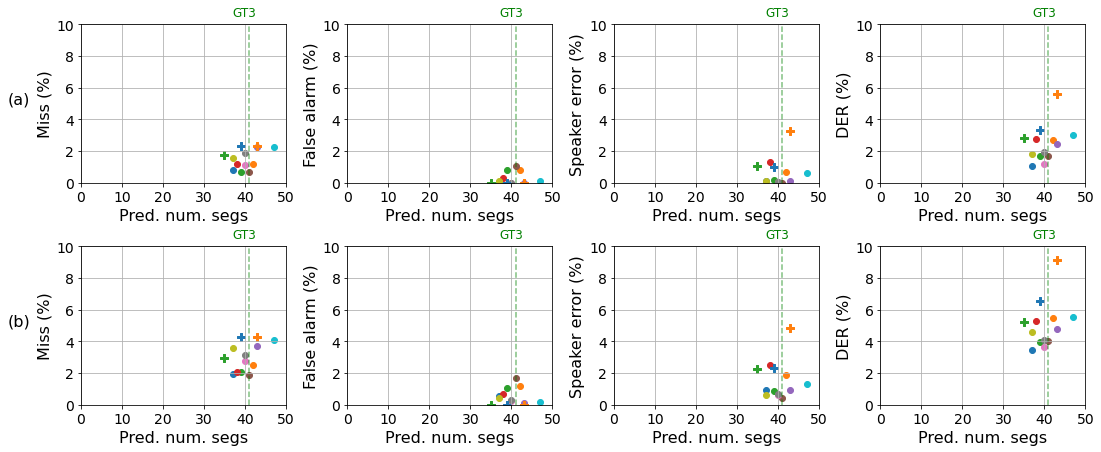

In [16]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(41, 0, 10, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(37, 10.5, "GT3", color="green", fontsize=12)

# System reviews
for i in range(len(dfs_sys)):
    axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P", s=60)
    axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P", s=60)
    axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P", s=60)
    axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P", s=60)
    
for i in range(len(dfs_sys)):
    axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P", s=60)
    axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P", s=60)
    axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P", s=60)
    axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P", s=60)
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 50])
        axes[i][j].set_ylim([0, 10])
        axes[i][j].set_xticks([10*i for i in range(6)])
        axes[i][j].set_yticks([2*i for i in range(6)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-18, 5, "(a)", fontsize=16)
axes[1][0].text(-18, 5, "(b)", fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220812_Graph_SAD_predNumSegs_GT3_pyannote.pdf", bbox_inches="tight", dpi=1200)

plt.show()

## Blank Reviews

In [44]:
# Review times manually recorded in minutes
review_times = [6, 7, 7, 14, 9, 11, 7, 6, 8, 8]

In [45]:
rpath = "../../HumanReviews/Reviews_Blank/"
lst_reviews = [file[:-4] for file in os.listdir(rpath)]
lst_reviews = natsorted(lst_reviews)
lst_reviews

['Blank_Reviewer1_1',
 'Blank_Reviewer1_2',
 'Blank_Reviewer1_3',
 'Blank_Reviewer1_4',
 'Blank_Reviewer1_5',
 'Blank_Reviewer1_6',
 'Blank_Reviewer1_7',
 'Blank_Reviewer1_8',
 'Blank_Reviewer1_9',
 'Blank_Reviewer1_10']

In [46]:
dfs = []
counts = []
agg_times = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
            if len(lineItems[2]) > 1 and lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            if "/" in lineItems[2]:
                lineItems[2] = lineItems[2].split("/")[0]
            txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1f', '2f', '3m', '4f', '?']
Number of speaker segments predicted by reviewer 1: 41
Total speech time predicted by reviewer 1: 230.12
Comb speech time predicted by reviewer 1: 220.32
Percent overlapping speech predicted by reviewer 1: 4.45%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1f', '2f', '3f', '3m', '4f']
Number of speaker segments predicted by reviewer 2: 41
Total speech time predicted by reviewer 2: 230.12
Comb speech time predicted by reviewer 2: 220.32
Percent overlapping speech predicted by reviewer 2: 4.45%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1F', '2F', '3F', '4M']
Number of speaker segments predicted by reviewer 3: 41
Total speech time predicted by reviewer 3: 230.12
Comb speech time predicted by reviewer 3: 220.32
Percent overlapping speech predicted by reviewer 3: 4.45%
Running md-eval-v21.pl scripts complete

Check set o

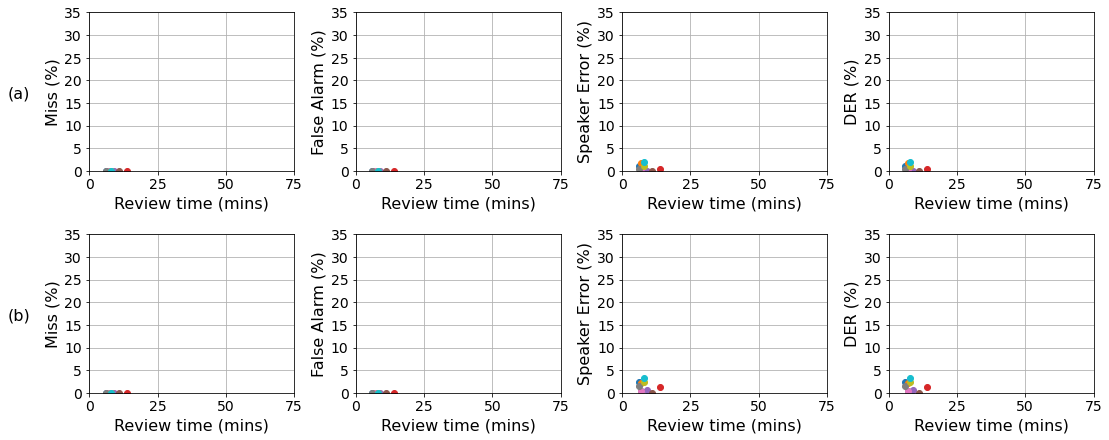

In [47]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False Alarm (%)", "Speaker Error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 16, "(a)",fontsize=16)
axes[1][0].text(-30, 16, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/220429_Graph_Blank_predSpchTime_GT3.pdf", bbox_inches="tight", dpi=1200)

plt.show()

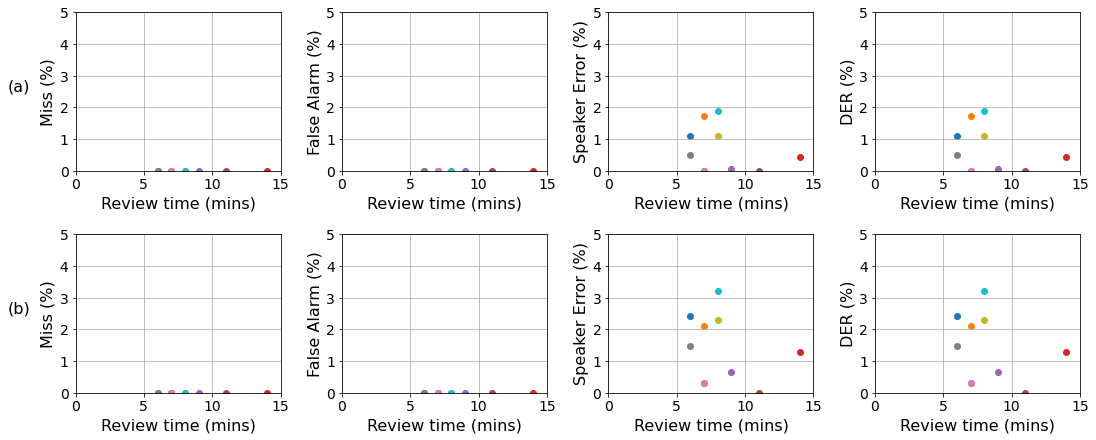

In [55]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False Alarm (%)", "Speaker Error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 15])
        axes[i][j].set_ylim([0, 5])
        axes[i][j].set_xticks([5*i for i in range(4)])
        axes[i][j].set_yticks([1*i for i in range(6)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-5, 2.5, "(a)",fontsize=16)
axes[1][0].text(-5, 2.5, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig("../../HumanReviews/graphs/2204510_Graph_Blank_predSpchTime_GT3.pdf", bbox_inches="tight", dpi=1200)

plt.show()

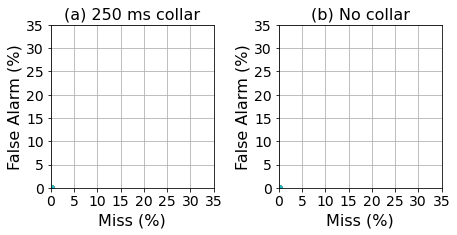

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False Alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 35])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([5*i for i in range(8)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a) 250 ms collar", fontsize=16)
axes[1].set_title("(b) No collar", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.show()

In [15]:
ders_250 = [dfs[i].iloc[0]["DER (%)"] for i in range(len(review_times))]
ders_0 = [dfs[i].iloc[-1]["DER (%)"] for i in range(len(review_times))]
print("Mean DER with 250 ms collars for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_250), np.std(ders_250)))
print("Mean DER with no collar for all reviewers is {:.2f}% and standard deviation is {:.2f}%".format(np.mean(ders_0), np.std(ders_0)))

Mean DER with 250 ms collars for all reviewers is 0.68% and standard deviation is 0.69%
Mean DER with no collar for all reviewers is 1.41% and standard deviation is 1.03%


In [23]:
for i in range(len(dfs)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,1.10,1.10
1,200,0.0,0.0,1.26,1.26
2,150,0.0,0.0,1.47,1.47
3,100,0.0,0.0,1.75,1.75
4,50,0.0,0.0,2.09,2.09
5,0,0.0,0.0,2.42,2.42


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,1.72,1.72
1,200,0.0,0.0,1.73,1.73
2,150,0.0,0.0,1.78,1.78
3,100,0.0,0.0,1.88,1.88
4,50,0.0,0.0,2.01,2.01
5,0,0.0,0.0,2.12,2.12


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,0.00,0.00
1,200,0.0,0.0,0.00,0.00
2,150,0.0,0.0,0.05,0.05
3,100,0.0,0.0,0.14,0.14
4,50,0.0,0.0,0.23,0.23
5,0,0.0,0.0,0.31,0.31


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,0.44,0.44
1,200,0.0,0.0,0.57,0.57
2,150,0.0,0.0,0.74,0.74
3,100,0.0,0.0,0.91,0.91
4,50,0.0,0.0,1.11,1.11
5,0,0.0,0.0,1.29,1.29


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,0.06,0.06
1,200,0.0,0.0,0.11,0.11
2,150,0.0,0.0,0.20,0.20
3,100,0.0,0.0,0.34,0.34
4,50,0.0,0.0,0.51,0.51
5,0,0.0,0.0,0.67,0.67


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,0.0,0.0
1,200,0.0,0.0,0.0,0.0
2,150,0.0,0.0,0.0,0.0
3,100,0.0,0.0,0.0,0.0
4,50,0.0,0.0,0.0,0.0
5,0,0.0,0.0,0.0,0.0


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,0.00,0.00
1,200,0.0,0.0,0.00,0.00
2,150,0.0,0.0,0.05,0.05
3,100,0.0,0.0,0.14,0.14
4,50,0.0,0.0,0.23,0.23
5,0,0.0,0.0,0.31,0.31


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,0.50,0.50
1,200,0.0,0.0,0.64,0.64
2,150,0.0,0.0,0.81,0.81
3,100,0.0,0.0,1.02,1.02
4,50,0.0,0.0,1.26,1.26
5,0,0.0,0.0,1.49,1.49


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,1.10,1.10
1,200,0.0,0.0,1.26,1.26
2,150,0.0,0.0,1.47,1.47
3,100,0.0,0.0,1.71,1.71
4,50,0.0,0.0,2.00,2.00
5,0,0.0,0.0,2.29,2.29


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,0.0,0.0,1.89,1.89
1,200,0.0,0.0,2.08,2.08
2,150,0.0,0.0,2.31,2.31
3,100,0.0,0.0,2.58,2.58
4,50,0.0,0.0,2.89,2.89
5,0,0.0,0.0,3.21,3.21


## Reviewer 1

In [3]:
# Convert Audacity output labels into .rttm file
#SPEAKER ES2008a 1 00010.462 01.898 <NA> <NA> FEE032 <NA>

pred_spkrs = []
txt = ""
with open("../../HumanReviews/Reviews/Reviewer1.txt", "r") as f:
    for line in f:
        lineItems = line.split()
        txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
        pred_spkrs.append(lineItems[2])
        
with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
    f.write(txt)

In [4]:
set(pred_spkrs)

{'1', '2', '3', '4'}

In [13]:
outputDir = "../../HumanReviews/results/"
audioname = "ES2008a"
oracleRttmFile = "rttm/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
df = AnalyseResults.getDERs(outputDir)
dfs.append(df)
display(df)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.87,4.35,0.98,11.20
1,200,6.45,4.91,1.11,12.46
2,150,7.02,5.52,1.25,13.79
3,100,7.64,6.12,1.41,15.16
4,50,8.33,6.75,1.60,16.68
5,0,9.09,7.45,1.82,18.36


## Reviewer 2

In [42]:
pred_spkrs = []
txt = ""
with open("../../HumanReviews/Reviews/Reviewer2.txt", "r") as f:
    for line in f:
        lineItems = line.split()
        txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
        pred_spkrs.append(lineItems[2])
        
with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
    f.write(txt)

In [43]:
set(pred_spkrs)

{'1', '2', '3', '4'}

In [44]:
import subprocess

myoutput = open(outputDir+"NISTEvaluation_2_5.txt", 'w')
#subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.25", "-u", audioname+".uem", "-r", oracleRttmFile, "-s", outputDir+audioname+".rttm"], stdout=myoutput)
subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.25", "-u", "../../HumanReviews/ES2008a.uem", "-r", oracleRttmFile, "-s", "../../HumanReviews/results/ES2008a.rttm"], stdout=myoutput)

CompletedProcess(args=['perl', 'md-eval-v21.pl', '-m', '-afc', '-c 0.25', '-u', '../../HumanReviews/ES2008a.uem', '-r', 'rttm/ES2008a.rttm', '-s', '../../HumanReviews/results/ES2008a.rttm'], returncode=0)

In [45]:
outputDir = "../../HumanReviews/results/"
audioname = "ES2008a"
oracleRttmFile = "rttm/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
AnalyseResults.getDERs(outputDir)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,10.41,1.73,1.49,13.62
1,200,10.93,2.10,1.63,14.66
2,150,11.45,2.63,1.76,15.84
3,100,11.98,3.12,1.92,17.02
4,50,12.55,3.64,2.08,18.28
5,0,13.24,4.27,2.29,19.80


## Reviewer 3

In [48]:
pred_spkrs = []
txt = ""
with open("../../HumanReviews/Reviews/Reviewer3.txt", "r") as f:
    for line in f:
        lineItems = line.split()
        txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
        pred_spkrs.append(lineItems[2])
        
with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
    f.write(txt)

In [49]:
set(pred_spkrs)

{'1', '2', '3', '4', '5'}

In [50]:
subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.25", "-u", "../../HumanReviews/ES2008a.uem", "-r", oracleRttmFile, "-s", "../../HumanReviews/results/ES2008a.rttm"], stdout=myoutput)

CompletedProcess(args=['perl', 'md-eval-v21.pl', '-m', '-afc', '-c 0.25', '-u', '../../HumanReviews/ES2008a.uem', '-r', 'rttm/ES2008a.rttm', '-s', '../../HumanReviews/results/ES2008a.rttm'], returncode=0)

In [51]:
outputDir = "../../HumanReviews/results/"
audioname = "ES2008a"
oracleRttmFile = "rttm/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
AnalyseResults.getDERs(outputDir)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,12.01,0.62,0.75,13.38
1,200,12.59,0.77,0.99,14.36
2,150,13.20,1.00,1.21,15.40
3,100,13.97,1.28,1.36,16.61
4,50,14.93,1.61,1.52,18.06
5,0,16.08,2.06,1.68,19.81


## Reviewer 4

In [57]:
pred_spkrs = []
txt = ""
with open("../../HumanReviews/Reviews/Reviewer4.txt", "r") as f:
    for line in f:
        lineItems = line.split()
        if lineItems[2][-1] == "?":
            lineItems[2] = lineItems[2][:-1]
        txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
        pred_spkrs.append(lineItems[2])
        
with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
    f.write(txt)

In [54]:
set(pred_spkrs)

{'1F', '2F', '2F?', '3F', '4F', '5F', '6M'}

In [58]:
set(pred_spkrs)

{'1F', '2F', '3F', '4F', '5F', '6M'}

In [55]:
subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.25", "-u", "../../HumanReviews/ES2008a.uem", "-r", oracleRttmFile, "-s", "../../HumanReviews/results/ES2008a.rttm"], stdout=myoutput)

CompletedProcess(args=['perl', 'md-eval-v21.pl', '-m', '-afc', '-c 0.25', '-u', '../../HumanReviews/ES2008a.uem', '-r', 'rttm/ES2008a.rttm', '-s', '../../HumanReviews/results/ES2008a.rttm'], returncode=0)

In [56]:
outputDir = "../../HumanReviews/results/"
audioname = "ES2008a"
oracleRttmFile = "rttm/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
AnalyseResults.getDERs(outputDir)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.59,1.21,2.24,11.04
1,200,8.41,1.45,2.45,12.31
2,150,9.37,1.76,2.65,13.78
3,100,10.40,2.11,2.88,15.40
4,50,11.56,2.51,3.10,17.16
5,0,12.78,2.96,3.29,19.03


In [59]:
subprocess.run(["perl", "md-eval-v21.pl", "-m", "-afc", "-c 0.25", "-u", "../../HumanReviews/ES2008a.uem", "-r", oracleRttmFile, "-s", "../../HumanReviews/results/ES2008a.rttm"], stdout=myoutput)

CompletedProcess(args=['perl', 'md-eval-v21.pl', '-m', '-afc', '-c 0.25', '-u', '../../HumanReviews/ES2008a.uem', '-r', 'rttm/ES2008a.rttm', '-s', '../../HumanReviews/results/ES2008a.rttm'], returncode=0)

In [60]:
outputDir = "../../HumanReviews/results/"
audioname = "ES2008a"
oracleRttmFile = "rttm/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
AnalyseResults.getDERs(outputDir)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.59,1.21,1.99,10.78
1,200,8.41,1.45,2.13,11.99
2,150,9.37,1.76,2.31,13.43
3,100,10.40,2.11,2.50,15.02
4,50,11.56,2.51,2.69,16.75
5,0,12.78,2.96,2.86,18.60


## Removing Non-Voice Sounds
I have just realised that the ground truth RTTM files I have been using (based on the XML segments files) include non-vocal sounds such as laughter and coughing, so I am removing that to see how much it affects results.

In [85]:
dfs = []
counts = []
agg_times = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "rttm/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 1: 35
Total speech time predicted by reviewer 1: 246.92
Comb speech time predicted by reviewer 1: 240.24
Percent overlapping speech predicted by reviewer 1: 2.78%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 2: 37
Total speech time predicted by reviewer 2: 228.53
Comb speech time predicted by reviewer 2: 220.72
Percent overlapping speech predicted by reviewer 2: 3.54%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1', '2', '3', '4', '5']
Number of speaker segments predicted by reviewer 3: 55
Total speech time predicted by reviewer 3: 219.58
Comb speech time predicted by reviewer 3: 218.33
Percent overlapping speech predicted by reviewer 3: 0.57%
Running md-eval-v21.pl scripts complete

Check set of predicted speake

In [86]:
for i in range(len(review_times)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,4.73,5.19,0.88,10.80
1,200,5.20,5.72,0.97,11.89
2,150,5.67,6.31,1.08,13.06
3,100,6.17,6.89,1.22,14.28
4,50,6.73,7.50,1.41,15.65
5,0,7.36,8.20,1.63,17.18


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,9.07,1.93,1.47,12.48
1,200,9.41,2.30,1.62,13.33
2,150,9.76,2.81,1.77,14.33
3,100,10.14,3.30,1.94,15.38
4,50,10.59,3.83,2.12,16.54
5,0,11.14,4.48,2.35,17.97


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,10.79,0.82,0.74,12.35
1,200,11.24,0.96,0.99,13.19
2,150,11.72,1.20,1.21,14.13
3,100,12.35,1.49,1.37,15.21
4,50,13.15,1.83,1.55,16.52
5,0,14.14,2.29,1.72,18.15


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.42,1.35,1.98,9.76
1,200,7.05,1.61,2.10,10.75
2,150,7.84,1.92,2.24,12.00
3,100,8.71,2.29,2.42,13.41
4,50,9.67,2.70,2.61,14.98
5,0,10.72,3.17,2.79,16.68


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.22,5.77,1.57,14.55
1,200,7.91,6.34,1.73,15.98
2,150,8.62,7.02,1.93,17.57
3,100,9.36,7.71,2.12,19.19
4,50,10.12,8.40,2.30,20.82
5,0,10.92,9.14,2.49,22.55


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,23.58,0.18,2.17,25.93
1,200,24.22,0.22,2.33,26.77
2,150,25.02,0.26,2.46,27.74
3,100,26.13,0.34,2.52,28.99
4,50,27.41,0.43,2.54,30.38
5,0,28.78,0.60,2.56,31.96


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.92,0.97,1.27,9.16
1,200,7.32,1.24,1.43,9.99
2,150,7.79,1.65,1.58,11.02
3,100,8.36,2.13,1.74,12.23
4,50,9.06,2.68,1.93,13.67
5,0,9.90,3.29,2.15,15.33


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.72,5.60,1.61,13.93
1,200,7.16,5.85,1.82,14.83
2,150,7.61,6.21,2.04,15.87
3,100,8.12,6.65,2.23,17.01
4,50,8.72,7.17,2.46,18.35
5,0,9.36,7.82,2.77,19.95


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.02,1.83,0.78,10.63
1,200,8.48,2.29,1.01,11.78
2,150,9.00,2.86,1.24,13.10
3,100,9.54,3.48,1.48,14.51
4,50,10.15,4.16,1.75,16.06
5,0,10.79,4.84,2.05,17.67


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,8.58,2.23,1.45,12.26
1,200,9.22,2.52,1.57,13.31
2,150,9.94,2.90,1.71,14.56
3,100,10.72,3.29,1.85,15.87
4,50,11.63,3.71,1.99,17.33
5,0,12.64,4.21,2.16,19.00


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.79,2.28,0.29,10.36
1,200,8.23,2.61,0.37,11.21
2,150,8.64,3.02,0.49,12.16
3,100,9.15,3.47,0.61,13.23
4,50,9.70,3.97,0.73,14.41
5,0,10.33,4.60,0.88,15.81


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.93,2.23,1.22,10.38
1,200,7.36,2.55,1.33,11.23
2,150,7.81,3.03,1.43,12.27
3,100,8.36,3.57,1.52,13.44
4,50,8.98,4.17,1.61,14.74
5,0,9.65,4.93,1.74,16.31


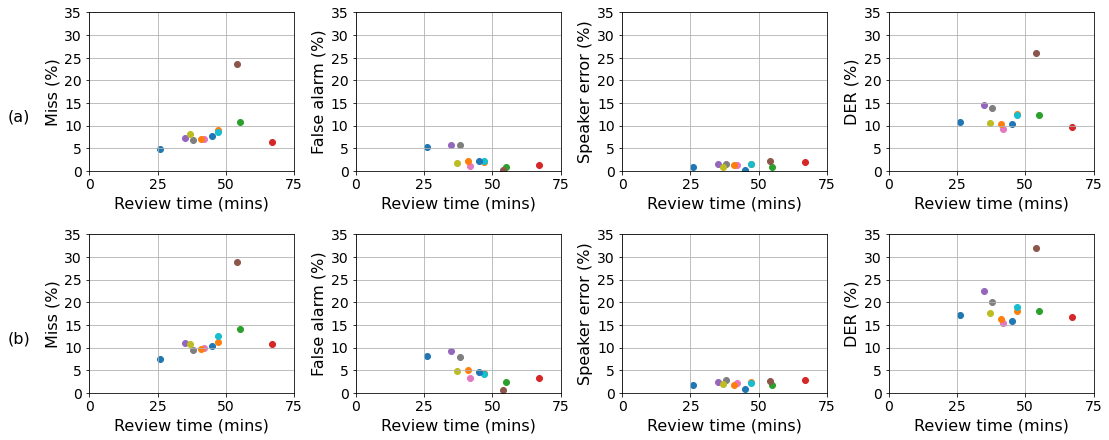

In [87]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 11, "(a)",fontsize=16)
axes[1][0].text(-30, 11, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

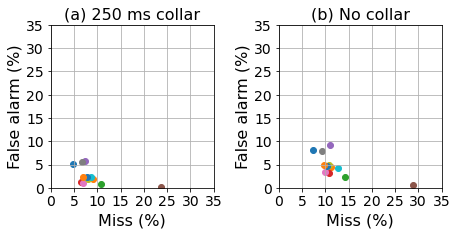

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 35])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([5*i for i in range(8)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a) 250 ms collar", fontsize=16)
axes[1].set_title("(b) No collar", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.show()

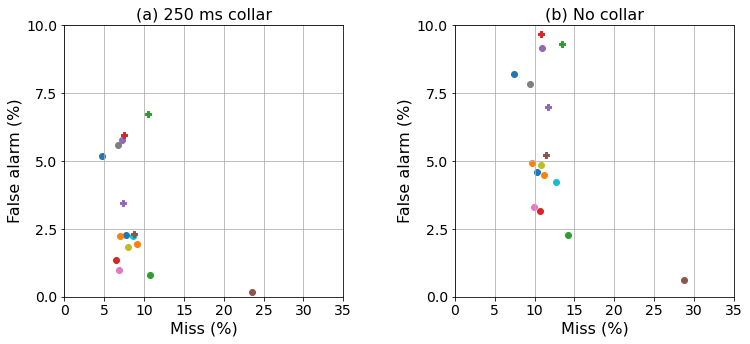

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i in range(len(review_times)):
    axes[0].scatter(dfs[i].iloc[0]["MISSED (%)"], dfs[i].iloc[0]["FALARM (%)"])
    axes[1].scatter(dfs[i].iloc[-1]["MISSED (%)"], dfs[i].iloc[-1]["FALARM (%)"])
    
for i in range(len(dfs_sys)):
    axes[0].scatter(dfs_sys[i].iloc[0]["MISSED (%)"], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
    axes[1].scatter(dfs_sys[i].iloc[-1]["MISSED (%)"], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")

plt.tick_params(labelsize=20)
for i in range(2):
    axes[i].set_xlabel("Miss (%)", fontsize=16)
    axes[i].set_ylabel("False alarm (%)", fontsize=16)
    axes[i].set_xlim([0, 35])
    axes[i].set_ylim([0, 10])
    axes[i].set_xticks([5*i for i in range(8)])
    axes[i].set_yticks([2.5*i for i in range(5)])
    axes[i].grid()
    for label in (axes[i].get_xticklabels() + axes[i].get_yticklabels()):
        label.set_fontsize(14)

axes[0].set_title("(a) 250 ms collar", fontsize=16)
axes[1].set_title("(b) No collar", fontsize=16)
        
plt.subplots_adjust(wspace=0.4)

plt.show()

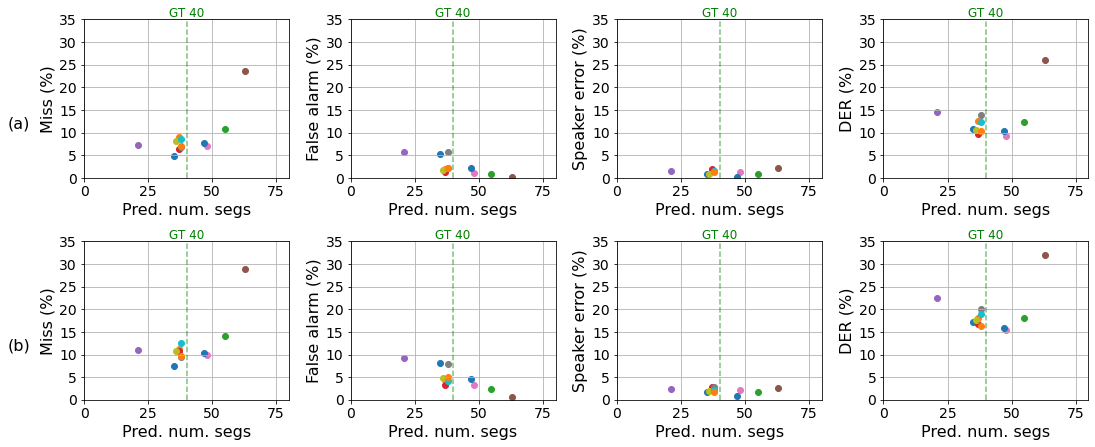

In [97]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(40, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(33, 35.5, "GT 40", color="green", fontsize=12)

# System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 11, "(a)",fontsize=16)
axes[1][0].text(-30, 11, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

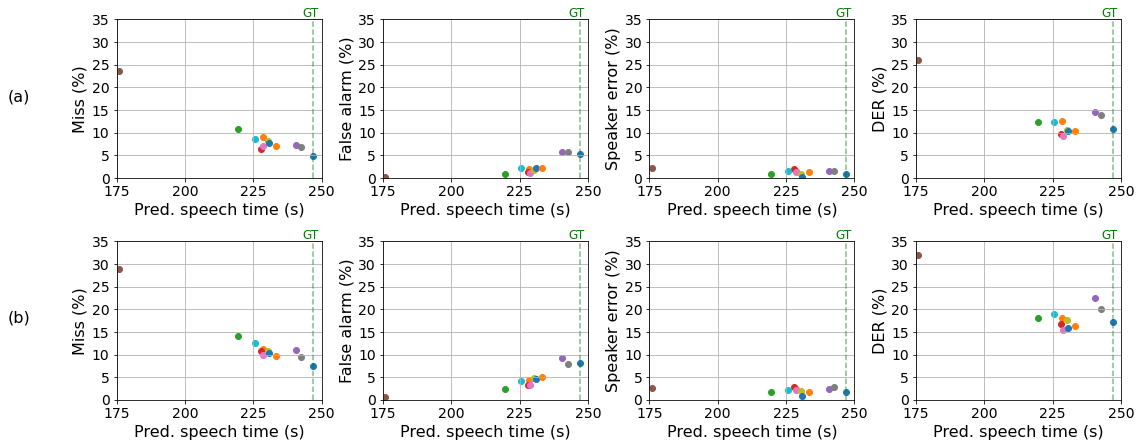

In [98]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(247.00, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(243, 35.5, "GT", color="green", fontsize=12)
    
# System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 250])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(135, 17, "(a)",fontsize=16)
axes[1][0].text(135, 17, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

## Removing Non-Voice Sounds 2
This time using the BUT versions for words only.

In [105]:
# Getting stats from BUT word-only RTTM file
import OverlapFunctions

rttmfile = "rttm/ES2008a.rttm"
timeSegsSpkr = OverlapFunctions.getSegsTimeSpkr(rttmfile)
combinedSegs, _ = OverlapFunctions.findCombinedSegs(timeSegsSpkr)

count = 0
agg_time = 0
for row in timeSegsSpkr:
    if row[0] > 30 and row[0] < 330:
        count += 1
        agg_time += round(row[1]-row[0])
        
print("There are {} vocal speech segments totalling {:.3f} secs.".format(len(timeSegsSpkr), agg_time))

There are 168 vocal speech segments totalling 228.000 secs.


In [99]:
dfs = []
counts = []
agg_times = []
for index, review in enumerate(lst_reviews):
    pred_spkrs = []
    pred_spkrs_segs = []
    txt = ""
    count = 0
    agg_time = 0
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            count += 1
            lineItems = line.split()
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            txt += "SPEAKER ES2008a 1 {} {} <NA> <NA> {} <NA>\n".format(lineItems[0], float(lineItems[1])-float(lineItems[0]), lineItems[2])
            pred_spkrs.append(lineItems[2])
            pred_spkrs_segs.append([float(lineItems[0]), float(lineItems[1])])
            agg_time += float(lineItems[1])-float(lineItems[0])

    with open("../../HumanReviews/results/ES2008a.rttm", "w") as f:
        f.write(txt)

    counts.append(count)
    agg_times.append(agg_time)
    comb_segs, _ = OverlapFunctions.findCombinedSegs(pred_spkrs_segs)
    comb_time = 0
    for row in comb_segs:
        comb_time += row[1] - row[0]
    print("Check set of predicted speakers for reviewer {}: {}".format(index+1, sorted(set(pred_spkrs))))
    print("Number of speaker segments predicted by reviewer {}: {}".format(index+1, count))
    print("Total speech time predicted by reviewer {}: {:.2f}".format(index+1, agg_time))
    print("Comb speech time predicted by reviewer {}: {:.2f}".format(index+1, comb_time))
    print("Percent overlapping speech predicted by reviewer {}: {:.2f}%".format(index+1, 100*(agg_time-comb_time)/comb_time))
        
    outputDir = "../../HumanReviews/results/"
    audioname = "ES2008a"
    oracleRttmFile = "rttm/ES2008a.rttm"
    uemFile = "../../HumanReviews/ES2008a.uem"
    runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
    df = AnalyseResults.getDERs(outputDir)
    dfs.append(df)
    #display(df)
    print()

Check set of predicted speakers for reviewer 1: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 1: 35
Total speech time predicted by reviewer 1: 246.92
Comb speech time predicted by reviewer 1: 240.24
Percent overlapping speech predicted by reviewer 1: 2.78%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 2: ['1', '2', '3', '4']
Number of speaker segments predicted by reviewer 2: 37
Total speech time predicted by reviewer 2: 228.53
Comb speech time predicted by reviewer 2: 220.72
Percent overlapping speech predicted by reviewer 2: 3.54%
Running md-eval-v21.pl scripts complete

Check set of predicted speakers for reviewer 3: ['1', '2', '3', '4', '5']
Number of speaker segments predicted by reviewer 3: 55
Total speech time predicted by reviewer 3: 219.58
Comb speech time predicted by reviewer 3: 218.33
Percent overlapping speech predicted by reviewer 3: 0.57%
Running md-eval-v21.pl scripts complete

Check set of predicted speake

In [100]:
for i in range(len(review_times)):
    display(dfs[i])

,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.80,6.94,0.75,9.48
1,200,2.06,7.71,0.87,10.64
2,150,2.40,8.47,1.01,11.88
3,100,2.84,9.25,1.17,13.27
4,50,3.29,10.10,1.37,14.75
5,0,3.77,11.07,1.59,16.44


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,6.24,3.17,1.28,10.69
1,200,6.41,3.80,1.42,11.63
2,150,6.65,4.48,1.55,12.68
3,100,6.93,5.18,1.70,13.81
4,50,7.21,5.90,1.91,15.03
5,0,7.52,6.83,2.12,16.48


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,7.97,1.27,0.61,9.84
1,200,8.22,1.62,0.78,10.63
2,150,8.65,2.04,0.95,11.64
3,100,9.14,2.54,1.13,12.82
4,50,9.66,3.15,1.31,14.13
5,0,10.22,4.02,1.53,15.77


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.66,2.31,1.71,7.68
1,200,3.98,2.71,1.90,8.59
2,150,4.45,3.20,2.11,9.76
3,100,5.10,3.76,2.36,11.23
4,50,5.90,4.40,2.57,12.88
5,0,6.75,5.12,2.81,14.69


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.24,9.06,1.22,15.52
1,200,5.78,9.88,1.40,17.05
2,150,6.44,10.71,1.60,18.74
3,100,7.16,11.53,1.79,20.47
4,50,7.88,12.31,2.01,22.20
5,0,8.60,13.12,2.23,23.96


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,21.38,0.34,1.67,23.39
1,200,21.66,0.40,1.88,23.95
2,150,22.20,0.50,2.09,24.79
3,100,22.90,0.64,2.29,25.83
4,50,23.81,0.85,2.48,27.15
5,0,24.80,1.22,2.71,28.73


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.83,1.92,1.44,7.20
1,200,4.11,2.60,1.63,8.34
2,150,4.53,3.32,1.79,9.64
3,100,5.10,4.07,1.95,11.12
4,50,5.69,4.87,2.16,12.72
5,0,6.37,5.74,2.39,14.50


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.99,7.00,1.10,12.09
1,200,4.25,7.54,1.26,13.05
2,150,4.55,8.13,1.47,14.15
3,100,4.93,8.81,1.72,15.47
4,50,5.31,9.61,2.03,16.96
5,0,5.78,10.53,2.36,18.66


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,4.57,3.40,0.48,8.46
1,200,4.93,4.19,0.63,9.75
2,150,5.38,5.02,0.78,11.18
3,100,5.94,5.80,1.00,12.74
4,50,6.58,6.57,1.25,14.40
5,0,7.33,7.40,1.53,16.26


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.83,3.60,0.94,10.37
1,200,6.19,4.11,1.00,11.30
2,150,6.71,4.64,1.10,12.45
3,100,7.42,5.19,1.23,13.83
4,50,8.16,5.75,1.42,15.33
5,0,8.97,6.41,1.62,16.99


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,4.64,3.26,0.37,8.26
1,200,4.89,3.91,0.41,9.21
2,150,5.24,4.59,0.47,10.29
3,100,5.66,5.31,0.61,11.58
4,50,6.19,6.14,0.77,13.10
5,0,6.79,7.09,0.95,14.83


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,3.80,3.10,0.81,7.71
1,200,4.05,3.66,0.95,8.66
2,150,4.35,4.31,1.09,9.74
3,100,4.70,5.03,1.27,10.99
4,50,5.07,5.88,1.51,12.46
5,0,5.54,6.91,1.74,14.19


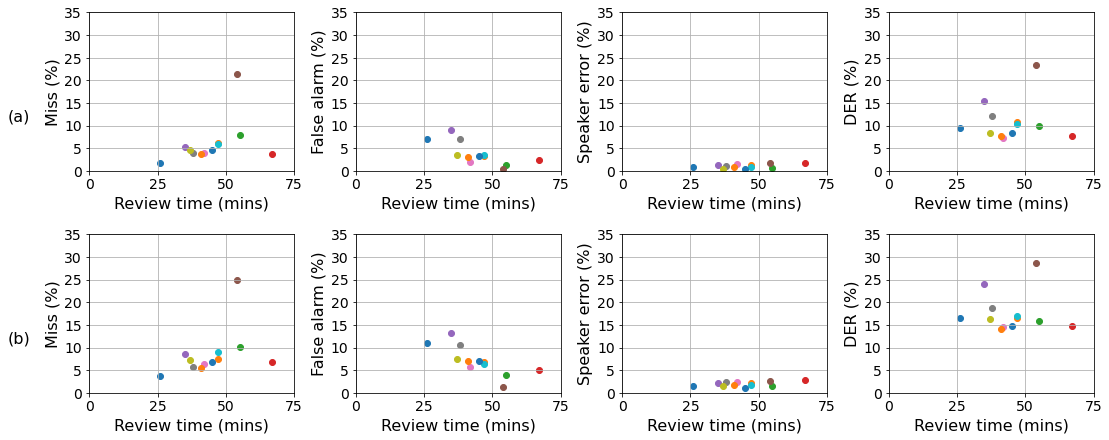

In [101]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

for i in range(len(review_times)):
    axes[0][0].scatter(review_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(review_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(review_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(review_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(review_times)):
    axes[1][0].scatter(review_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(review_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(review_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(review_times[i], dfs[i].iloc[-1]["DER (%)"])
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Review time (mins)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 75])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 11, "(a)",fontsize=16)
axes[1][0].text(-30, 11, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

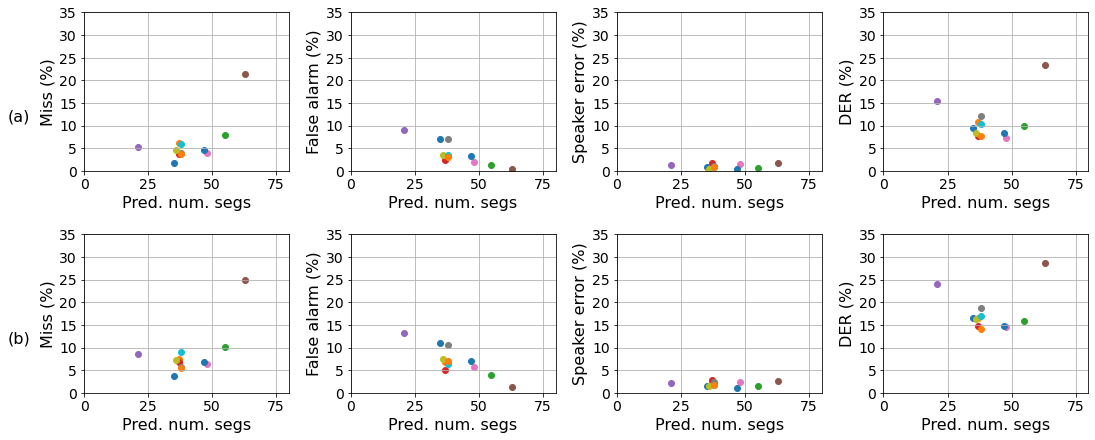

In [108]:
# This time excluding number of ground truth segments as well off scale
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(counts)):
    axes[0][0].scatter(counts[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(counts[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(counts[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(counts[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(counts)):
    axes[1][0].scatter(counts[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(counts[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(counts[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(counts[i], dfs[i].iloc[-1]["DER (%)"])
    
# for i in range(2):
#     for j in range(4):
#         axes[i][j].axvline(40, 0, 35, color="green", linestyle="--", alpha=0.5)
#         axes[i][j].text(33, 35.5, "GT 40", color="green", fontsize=12)

# System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(counts_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(counts_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(counts_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(counts_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(counts_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. num. segs", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([0, 80])
        axes[i][j].set_ylim([0, 35])
        axes[i][j].set_xticks([25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(8)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(-30, 11, "(a)",fontsize=16)
axes[1][0].text(-30, 11, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

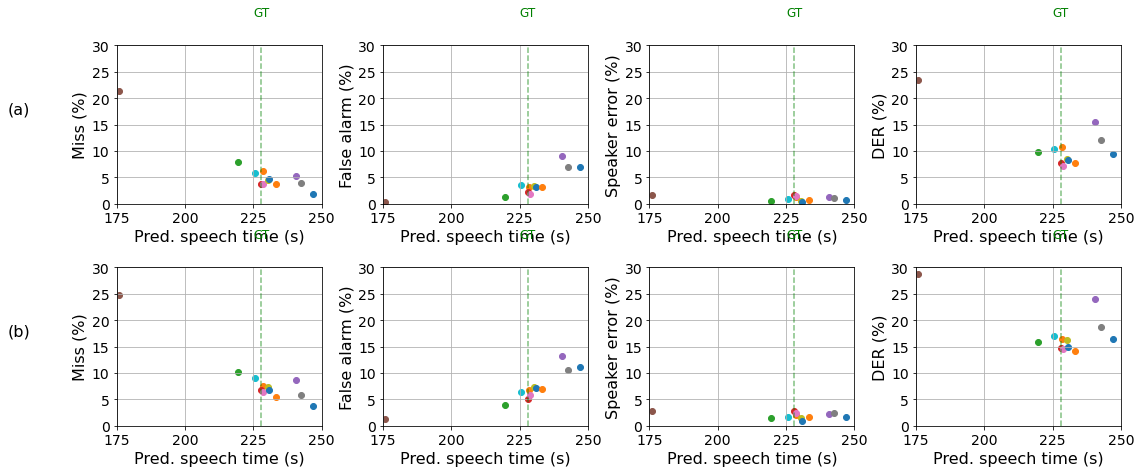

In [111]:
nPlots = 4
fig, axes = plt.subplots(2, nPlots, figsize=(18, 7))
cols = ["Miss (%)", "False alarm (%)", "Speaker error (%)", "DER (%)"]

# Human reviews
for i in range(len(agg_times)):
    axes[0][0].scatter(agg_times[i], dfs[i].iloc[0]["MISSED (%)"])
    axes[0][1].scatter(agg_times[i], dfs[i].iloc[0]["FALARM (%)"])
    axes[0][2].scatter(agg_times[i], dfs[i].iloc[0]["ERROR (%)"])
    axes[0][3].scatter(agg_times[i], dfs[i].iloc[0]["DER (%)"])

for i in range(len(agg_times)):
    axes[1][0].scatter(agg_times[i], dfs[i].iloc[-1]["MISSED (%)"])
    axes[1][1].scatter(agg_times[i], dfs[i].iloc[-1]["FALARM (%)"])
    axes[1][2].scatter(agg_times[i], dfs[i].iloc[-1]["ERROR (%)"])
    axes[1][3].scatter(agg_times[i], dfs[i].iloc[-1]["DER (%)"])
    
for i in range(2):
    for j in range(4):
        axes[i][j].axvline(228.00, 0, 35, color="green", linestyle="--", alpha=0.5)
        axes[i][j].text(225, 35.5, "GT", color="green", fontsize=12)
    
# System reviews
# for i in range(len(dfs_sys)):
#     axes[0][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["MISSED (%)"], marker="P")
#     axes[0][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["FALARM (%)"], marker="P")
#     axes[0][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["ERROR (%)"], marker="P")
#     axes[0][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[0]["DER (%)"], marker="P")
    
# for i in range(len(dfs_sys)):
#     axes[1][0].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["MISSED (%)"], marker="P")
#     axes[1][1].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["FALARM (%)"], marker="P")
#     axes[1][2].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["ERROR (%)"], marker="P")
#     axes[1][3].scatter(agg_times_sys[i], dfs_sys[i].iloc[-1]["DER (%)"], marker="P")
    
plt.tick_params(labelsize=20)
for i in range(2):
    for j in range(nPlots):
        axes[i][j].set_xlabel("Pred. speech time (s)", fontsize=16)
        axes[i][j].set_ylabel(cols[j], fontsize=16)
        axes[i][j].set_xlim([175, 250])
        axes[i][j].set_ylim([0, 30])
        axes[i][j].set_xticks([175+25*i for i in range(4)])
        axes[i][j].set_yticks([5*i for i in range(7)])
        axes[i][j].grid()
        for label in (axes[i][j].get_xticklabels() + axes[i][j].get_yticklabels()):
            label.set_fontsize(14)

axes[0][0].text(135, 17, "(a)",fontsize=16)
axes[1][0].text(135, 17, "(b)",fontsize=16)
            
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

## Getting BUT DIHARD II Outputs for Comparison
- Original BUT DIHARD II code in ../VBX_v1 (BDII)
- Revised code using ResNet101 x-vectors in ../VBx (ResNet)
- I had to refer to the relevant GT files in the relevant files

In [1]:
!pwd

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/rds/general/user/swm1718/home/ModulationSpectrum/LSTM


### Running BUT Systems

In [ ]:
# BDII

#os.chdir("VBx_v1")
subprocess.run(["bash", "run_ES2008_GT.sh", "all", "eval", "ES2008", "gt1"])

bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'


Testing!
Here!


/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
./extract.py:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not os.path.exists(dir_name) and (dir_name is not ''):
  0%|                                                                     | 0/23387 [00:00<?, ?it/s][W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Loading component tdnn1.affine
 Weights loaded
 Bias loaded
Loading batchnorm tdnn1.affine
 Batchnorm mean loaded
 Batchnorm variance loaded
Loading component tdnn1a.affine
 Weights loaded
 Bias loaded
Loading batchnorm tdnn1a.affine
 Batchnorm mean loaded
 Batchnorm variance loaded
Loading component tdnn2.affine
 Weights loaded
 Bias loaded
Loading batchnorm tdnn2.affine
 Batchnorm mean loaded
 Batchnorm variance loaded
Loading component tdnn2a.affine
 Weights loaded
 Bias loaded
Loading batchnorm tdnn2a.affine
 Batchnorm mean loaded
 Batchnorm variance loaded
Loading component tdnn3.affine
 Weights loaded
 Bias loaded
Loading batchnorm tdnn3.affine
 Batchnorm mean loaded
 Batchnorm variance loaded
Loading component tdnn3a.affine
 Weights loaded
 Bias loaded
Loading batchnorm tdnn3a.affine
 Batchnorm mean loaded
 Batchnorm variance loaded
Loading component tdnn4.affine
 Weights loaded
 Bias loaded
Loading batchnorm tdnn4.affine
 Batchnorm mean loaded
 Batchnorm variance loaded
Loading

/rds/general/user/swm1718/home/anaconda3/envs/tf2py38mamba_new/lib/python3.8/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 29%|████████████████▋                                         | 6722/23387 [08:12<20:31, 13.53it/s]

In [6]:
# BDII

#os.chdir("VBx_v1")
subprocess.run(["bash", "run_ES2008_GT.sh", "score", "eval", "ES2008", "gt1", "../dscore"])

bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'


File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  ------  ----  -------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
ES2008a            7.41  0.00     7.98  15.39  16.97            0.85         0.86     0.86             0.83             0.81          0.55          0.40  1.98   0.81
ES2008b            9.32  0.02     4.46  13.81  15.49            0.84         0.90     0.87             0.88             0.80          0.63          0.33  2.12   0.82
ES2008c           17.24  0.01     6.53  23.79  23.68            0.72         0.83     0.77             0.80             0.67          0.96          0.50  2.02   0.74
ES2008d           16.77  0.02     8.09  24.89  27.19            0.71         0.81     0.76             0.77             0.65          1.07          0.59  1.87   0.69
*** 

Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...
Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...
Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...
Checking for overlapping reference speaker turns...


File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  ------  ----  -------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
ES2008a            7.85  0.00     6.97  14.82  17.46            0.86         0.88     0.87             0.85             0.81          0.49          0.34  1.98   0.83
ES2008b            9.32  0.02     4.46  13.81  15.49            0.84         0.90     0.87             0.88             0.80          0.63          0.33  2.12   0.82
ES2008c           17.24  0.01     6.53  23.79  23.68            0.72         0.83     0.77             0.80             0.67          0.96          0.50  2.02   0.74
ES2008d           16.77  0.02     8.09  24.89  27.19            0.71         0.81     0.76             0.77             0.65          1.07          0.59  1.87   0.69
*** 

Checking for overlapping system speaker turns...
Scoring...


CompletedProcess(args=['bash', 'run_ES2008_GT.sh', 'score', 'eval', 'ES2008', 'gt1', '../dscore'], returncode=0)

In [ ]:
# BDII

#os.chdir("../VBx")
subprocess.run(["bash", "run_ES2008_GT.sh", "all", "eval", "ES2008", "gt3"])

In [7]:
# BDII

#os.chdir("../VBx_v1")
subprocess.run(["bash", "run_ES2008_GT.sh", "score", "eval", "ES2008", "gt3", "../dscore"])

bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...
Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...


File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  ------  ----  -------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
ES2008a            3.81  0.00     5.73   9.55  10.77            0.92         0.91     0.92             0.89             0.90          0.30          0.28  2.08   0.88
ES2008b            5.83  0.00     4.24  10.08  10.83            0.89         0.92     0.90             0.90             0.87          0.42          0.29  2.18   0.86
ES2008c           11.00  0.00     4.83  15.82  15.77            0.81         0.89     0.85             0.86             0.77          0.68          0.38  2.09   0.80
ES2008d           10.05  0.00     6.59  16.64  19.16            0.79         0.86     0.83             0.82             0.75          0.76          0.45  1.94   0.76
*** 

Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...


File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  ------  ----  -------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
ES2008a            4.26  0.00     4.86   9.12  12.07            0.95         0.95     0.95             0.93             0.94          0.18          0.16  2.13   0.93
ES2008b            5.83  0.00     4.24  10.08  10.83            0.89         0.92     0.90             0.90             0.87          0.42          0.29  2.18   0.86
ES2008c           11.00  0.00     4.83  15.82  15.77            0.81         0.89     0.85             0.86             0.77          0.68          0.38  2.09   0.80
ES2008d           10.05  0.00     6.59  16.64  19.16            0.79         0.86     0.83             0.82             0.75          0.76          0.45  1.94   0.76
*** 

Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...


CompletedProcess(args=['bash', 'run_ES2008_GT.sh', 'score', 'eval', 'ES2008', 'gt3', '../dscore'], returncode=0)

In [27]:
os.chdir("..")

In [ ]:
# ResNet

#os.chdir("VBx")
subprocess.run(["bash", "run_ES2008_gt1.sh"])

bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 16:01:45.236822796 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs]

ES2008a
AHC, no random seed


/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 16:05:45.286272721 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'metric.weight'. It is not used by any node and should be removed from the model.
2022-05-04 16:05:45.286321779 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'layer4.2.bn3.num_batches_tracked'. It is not used by any node and should be removed from the model.
2022-05-04 16:05:45.286332733 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer

ES2008b
AHC, no random seed


/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 16:17:24.809176966 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'metric.weight'. It is not used by any node and should be removed from the model.
2022-05-04 16:17:24.809226811 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'layer4.2.bn3.num_batches_tracked'. It is not used by any node and should be removed from the model.
2022-05-04 16:17:24.809237707 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer

ES2008c
AHC, no random seed


/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 16:30:05.349445641 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'metric.weight'. It is not used by any node and should be removed from the model.
2022-05-04 16:30:05.349495986 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'layer4.2.bn3.num_batches_tracked'. It is not used by any node and should be removed from the model.
2022-05-04 16:30:05.349506953 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer

In [12]:
#One above had wrong rttm files for scoring

!python ../dscore/score.py --collar 0.0 -u ES2008/eval.uem -r ../testingModSpecLSTM/rttm_laugh/*.rttm -s ES2008/exp_gt1/*.rttm
!python ../dscore/score.py --collar 0.0 -u ES2008/eval_humanreviews.uem -r ../testingModSpecLSTM/rttm_laugh/*.rttm -s ES2008/exp_gt1/*.rttm

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...
Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...
File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
--

In [13]:
# ResNet

#os.chdir("../VBx")
subprocess.run(["bash", "run_ES2008_gt3.sh"])

bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'
bash: scl: line 1: syntax error: unexpected end of file
bash: error importing function definition for `scl'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 13:16:32.123928614 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs]

ES2008a
AHC, no random seed


/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 13:20:17.260652805 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'metric.weight'. It is not used by any node and should be removed from the model.
2022-05-04 13:20:17.260704761 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'layer4.2.bn3.num_batches_tracked'. It is not used by any node and should be removed from the model.
2022-05-04 13:20:17.260715535 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer

ES2008b
AHC, no random seed


/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 13:30:25.855050060 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'metric.weight'. It is not used by any node and should be removed from the model.
2022-05-04 13:30:25.855103749 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'layer4.2.bn3.num_batches_tracked'. It is not used by any node and should be removed from the model.
2022-05-04 13:30:25.855119747 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer

ES2008c
AHC, no random seed


/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
2022-05-04 13:41:04.612878510 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'metric.weight'. It is not used by any node and should be removed from the model.
2022-05-04 13:41:04.612931454 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer 'layer4.2.bn3.num_batches_tracked'. It is not used by any node and should be removed from the model.
2022-05-04 13:41:04.612947710 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer

ES2008d
AHC, no random seed


Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...
Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...


File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  ------  ----  -------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
ES2008a            3.81  0.00    15.20  19.01  21.22            0.93         0.79     0.86             0.74             0.91          0.24          0.79  2.14   0.81
ES2008b            5.83  0.00     7.33  13.17  14.09            0.90         0.87     0.89             0.84             0.88          0.39          0.54  2.21   0.83
ES2008c           11.00  0.00    11.77  22.77  24.16            0.32         0.85     0.47             0.55             0.18          2.09          0.65  0.69   0.36
ES2008d           10.05  0.00    20.42  30.47  31.75            0.29         0.87     0.44             0.49             0.13          2.21          0.55  0.49   0.29
*** 

Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...


File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
---------------  ------  ----  -------  -----  -----  --------------  -----------  -------  ---------------  ---------------  ------------  ------------  ----  -----
ES2008a            4.26  0.00    28.45  32.71  31.20            0.95         0.73     0.82             0.67             0.93          0.15          0.90  2.16   0.81
ES2008b            5.83  0.00     7.33  13.17  14.09            0.90         0.87     0.89             0.84             0.88          0.39          0.54  2.21   0.83
ES2008c           11.00  0.00    11.77  22.77  24.16            0.32         0.85     0.47             0.55             0.18          2.09          0.65  0.69   0.36
ES2008d           10.05  0.00    20.42  30.47  31.75            0.29         0.87     0.44             0.49             0.13          2.21          0.55  0.49   0.29
*** 

Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...


CompletedProcess(args=['bash', 'run_ES2008_gt3.sh'], returncode=0)

In [4]:
# Running this cell as cell above was not saved in time before Jupyter shut down
os.chdir("VBx")
!python ../dscore/score.py --collar 0.0 -u ES2008/eval.uem -r ../testingModSpecLSTM/rttm/*.rttm -s ES2008/exp_gt3/*.rttm
!python ../dscore/score.py --collar 0.0 -u ES2008/eval_humanreviews.uem -r ../testingModSpecLSTM/rttm/*.rttm -s ES2008/exp_gt3/*.rttm

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Loading universal evaluation map...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...
Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...
File               MISS    FA    ERROR    DER    JER    B3-Precision    B3-Recall    B3-F1    GKT(ref, sys)    GKT(sys, ref)    H(ref|sys)    H(sys|ref)    MI    NMI
--

In [5]:
os.chdir("..")

In [6]:
outputDir = "VBx_v1/ES2008/out_dir_gt1/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm_laugh/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
dfResults = AnalyseResults.getDERs(outputDir)
display(dfResults)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.11,0.0,5.58,10.70
1,200,5.63,0.0,5.84,11.46
2,150,6.12,0.0,6.14,12.25
3,100,6.65,0.0,6.41,13.06
4,50,7.24,0.0,6.68,13.91
5,0,7.85,0.0,6.97,14.82


In [5]:
outputDir = "VBx_v1/ES2008/out_dir_gt3/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
dfResults = AnalyseResults.getDERs(outputDir)
display(dfResults)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,2.31,0.0,3.29,5.59
1,200,2.58,0.0,3.47,6.05
2,150,2.94,0.0,3.72,6.66
3,100,3.37,0.0,4.06,7.43
4,50,3.81,0.0,4.46,8.27
5,0,4.26,0.0,4.86,9.12


In [8]:
rttmfile = outputDir + audioname + ".rttm"
timeSegsSpkr = OverlapFunctions.getSegsTimeSpkr(rttmfile)
combinedSegs, _ = OverlapFunctions.findCombinedSegs(timeSegsSpkr)

count = 0
agg_time = 0
for row in timeSegsSpkr:
    if row[0] > 30 and row[0] < 330:
        count += 1
        agg_time += round(row[1]-row[0])
        
print("There are {} vocal speech segments totalling {:.3f} secs.".format(count, agg_time))

There are 43 vocal speech segments totalling 218.000 secs.


In [8]:
outputDir = "VBx/ES2008/exp_gt1/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm_laugh/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
dfResults = AnalyseResults.getDERs(outputDir)
display(dfResults)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,5.11,0.0,3.20,8.32
1,200,5.63,0.0,3.51,9.14
2,150,6.12,0.0,3.84,9.95
3,100,6.65,0.0,4.14,10.80
4,50,7.24,0.0,4.43,11.66
5,0,7.85,0.0,4.70,12.55


In [9]:
outputDir = "VBx/ES2008/exp_gt3/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
uemFile = "../../HumanReviews/ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
dfResults = AnalyseResults.getDERs(outputDir)
display(dfResults)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,2.31,0.0,1.02,3.33
1,200,2.58,0.0,1.15,3.73
2,150,2.94,0.0,1.34,4.28
3,100,3.37,0.0,1.62,5.00
4,50,3.81,0.0,1.95,5.77
5,0,4.26,0.0,2.29,6.55


In [10]:
rttmfile = outputDir + audioname + ".rttm"
timeSegsSpkr = OverlapFunctions.getSegsTimeSpkr(rttmfile)
combinedSegs, _ = OverlapFunctions.findCombinedSegs(timeSegsSpkr)

count = 0
agg_time = 0
for row in timeSegsSpkr:
    if row[0] > 30 and row[0] < 330:
        count += 1
        agg_time += round(row[1]-row[0])
        
print("There are {} vocal speech segments totalling {:.3f} secs.".format(count, agg_time))

There are 39 vocal speech segments totalling 220.000 secs.


### Using GT1 SAD

In [3]:
# This is for the original DIHARD II code
outputDir = "VBx_v1/ES2008/out_dir_eval/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
uemFile = "ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
dfResults = AnalyseResults.getDERs(outputDir)
display(dfResults)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.51,2.00,4.21,7.72
1,200,1.76,2.18,4.42,8.36
2,150,2.14,2.39,4.69,9.21
3,100,2.62,2.69,4.96,10.27
4,50,3.20,3.14,5.25,11.59
5,0,3.83,4.05,5.56,13.43


In [4]:
# This is for the revised DIHARD II code using ResNet101 x-vectors
outputDir = "VBx/ES2008/exp/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
uemFile = "ES2008a.uem"
runPerlCollarsUem2(outputDir, audioname, oracleRttmFile, uemFile)
dfResults = AnalyseResults.getDERs(outputDir)
display(dfResults)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.51,2.00,3.48,6.99
1,200,1.76,2.18,3.71,7.65
2,150,2.14,2.39,4.00,8.53
3,100,2.62,2.69,4.34,9.64
4,50,3.20,3.14,4.68,11.03
5,0,3.83,4.05,5.03,12.90


### Using GT3 SAD

## Graph

In [25]:
rttmfile = "testingModSpecLSTM/rttm/ES2008a.rttm"
timeSegsSpkr = OverlapFunctions.getSegsTimeSpkr(rttmfile)
combinedSegs, _ = OverlapFunctions.findCombinedSegs(timeSegsSpkr)
len(timeSegsSpkr)

168

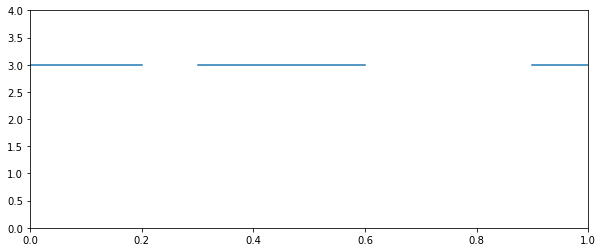

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.set_ylim([0, 4])

# Duration of extract
maxlen = 330.5

ax.axhline(3, 0, 0.2)
ax.axhline(3, 0.3, 0.6)
ax.axhline(3, 0.9, 1.0)

plt.show()

In [27]:
num_to_spkr = {
    0: "FEE029",
    1: "FEE030",
    2: "MEE031",
    3: "FEE032"
}

spkr_to_num = {
    "FEE029": 0,
    "FEE030": 1,
    "MEE031": 2,
    "FEE032": 3
}

colours = ["b", "r", "g", "orange", "pink", "purple"]

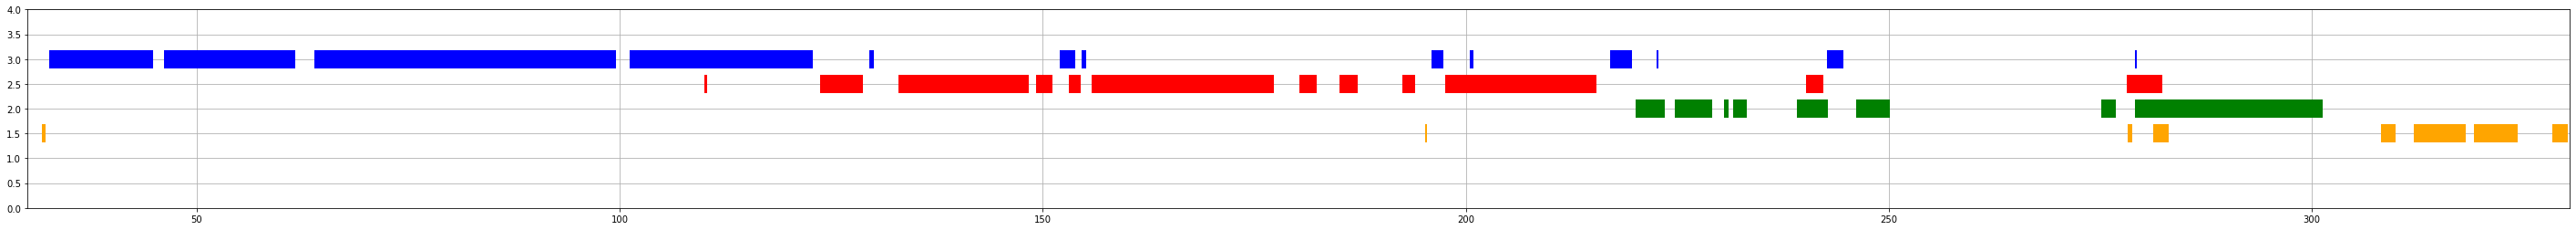

In [29]:
fig, ax = plt.subplots(figsize=(50, 4))

ax.set_xlim(30, 330.5)
ax.set_ylim([0, 4])
#ax.set_xticks[]

# Duration of extract
maxlen = 300.5

for row in timeSegsSpkr:
    if row[0] > 30 and row[0] < 330:
        #ax.axhline(3-spkr_to_num[row[2]]*0.5, (row[0]-30)/maxlen, (row[1]-30)/maxlen, c=colours[spkr_to_num[row[2]]], linewidth=20)
        ax.hlines(3-spkr_to_num[row[2]]*0.5, row[0], row[1], color=colours[spkr_to_num[row[2]]], linewidth=20)

ax.grid()    

plt.show()

In [108]:
timeSegsSpkrs = []
for index, review in enumerate(lst_reviews):
    tSS = []
    with open(rpath + review + ".txt", "r") as f:
        for line in f:
            lineItems = line.split()
            if lineItems[2][-1] == "?":
                lineItems[2] = lineItems[2][:-1]
            # NEED TO SORT OUT GETTING INT FROM TYPING 1f, 3M ETC
            tSS.append([float(lineItems[0]), float(lineItems[1]), int(lineItems[2][0])])
    timeSegsSpkrs.append(tSS)
            
len(timeSegsSpkrs)

13

In [109]:
tSS

[[32.567737, 44.417326, 1],
 [46.354994, 61.81908, 1],
 [63.961694, 122.911534, 1],
 [110.149006, 110.670686, 2],
 [123.582266, 129.358009, 2],
 [129.395271, 130.345474, 1],
 [132.842086, 169.471474, 2],
 [151.846143, 152.908134, 1],
 [154.717712, 155.018144, 1],
 [171.562852, 177.494633, 2],
 [180.294005, 182.383054, 2],
 [185.007757, 185.952137, 2],
 [186.813259, 187.269146, 2],
 [192.456253, 192.890016, 2],
 [193.509511, 194.033519, 2],
 [194.870769, 195.374982, 2],
 [195.90132, 197.327207, 1],
 [197.489067, 215.444524, 2],
 [200.65117, 201.009825, 1],
 [216.979288, 219.401374, 1],
 [219.438637, 233.193289, 3],
 [222.515151, 222.796952, 1],
 [238.847927, 242.762856, 3],
 [240.371047, 242.259808, 2],
 [242.676686, 244.664427, 1],
 [246.174737, 248.935682, 3],
 [265.211399, 265.604988, 1],
 [274.99057, 276.73552, 3],
 [277.753262, 278.272613, 1],
 [278.199834, 278.92413, 2],
 [278.980025, 281.651306, 3],
 [279.019616, 279.18497, 1],
 [279.388169, 283.126682, 3],
 [283.537738, 301.3260

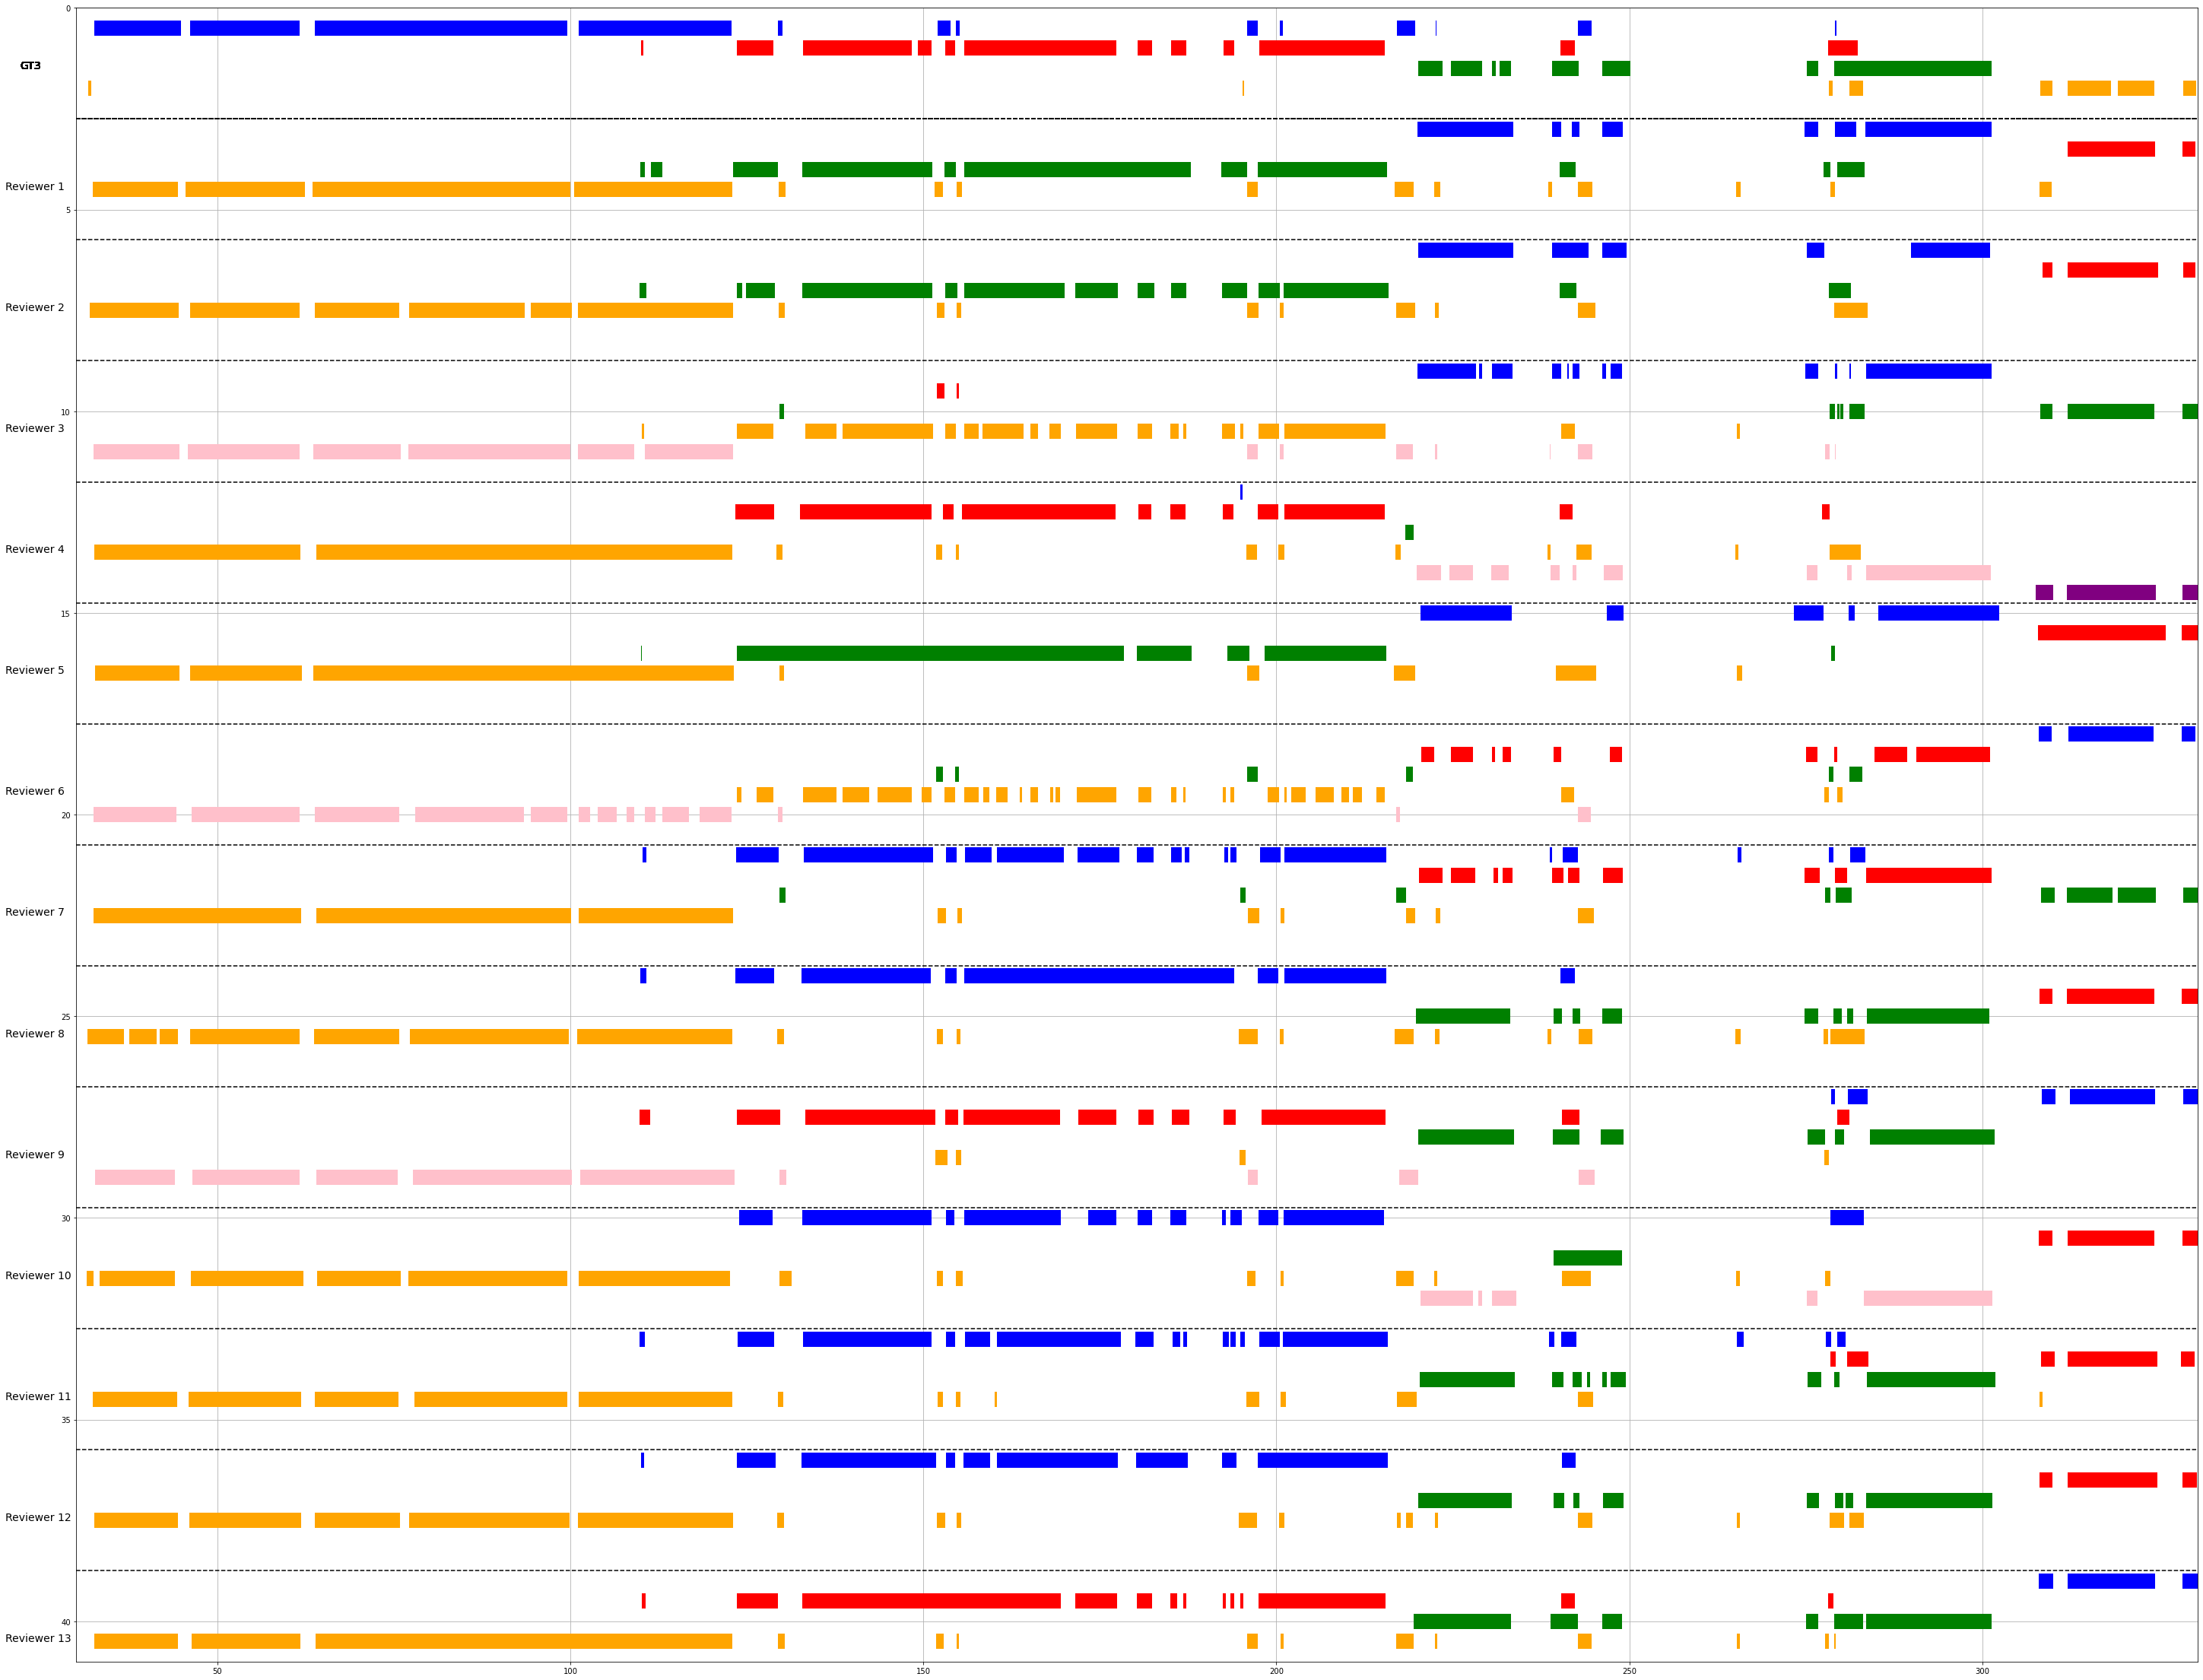

In [83]:
fig, ax = plt.subplots(figsize=(50, 40))

ax.set_xlim(30, 330.5)
ax.set_ylim([0, 41])
ax.invert_yaxis()
#ax.set_xticks[]

# Duration of extract
maxlen = 300.5

for row in timeSegsSpkr:
    if row[0] > 30 and row[0] < 330:
        #ax.axhline(3-spkr_to_num[row[2]]*0.5, (row[0]-30)/maxlen, (row[1]-30)/maxlen, c=colours[spkr_to_num[row[2]]], linewidth=20)
        ax.hlines(0.5 + spkr_to_num[row[2]]*0.5, row[0], row[1], color=colours[spkr_to_num[row[2]]], linewidth=20)
    ax.hlines(2.75, 30, 330.5, color="k", linestyle="--")
    ax.text(22, 1.5, "GT3", fontsize=14)
        
for ind, tSS in enumerate(timeSegsSpkrs):
    pred_spkrs = set([row[2] for row in tSS])
    pred_spkr_to_num = {}
    for k, v in enumerate(pred_spkrs):
        pred_spkr_to_num[v] = k
    for row in tSS:
        ax.hlines(3+3*ind+pred_spkr_to_num[row[2]]*0.5, row[0], row[1], color=colours[pred_spkr_to_num[row[2]]], linewidth=20)
    ax.hlines(2.75+3*ind, 30, 330.5, color="k", linestyle="--")
    ax.text(20, 4.5+3*ind, "Reviewer {}".format(ind+1), fontsize=14)
        
ax.grid()    

plt.show()

In [73]:
pred_spkr_to_num

{1: 0, 2: 1, 3: 2, 4: 3}

In [62]:
a = set([row[2] for row in tSS])
a

{1, 2, 3, 4}

In [67]:
for k, v in enumerate(a):
    print(k)
    print(v)
    print()

0
1

1
2

2
3

3
4



In [49]:
timeSegsSpkrs[1]

[[31.971531, 44.566377, '1'],
 [46.10347, 61.663042, '1'],
 [63.838261, 75.783336, '1'],
 [77.176035, 93.506482, '1'],
 [94.374008, 100.218454, '1'],
 [101.047553, 123.097849, '1'],
 [109.776377, 110.745211, '2'],
 [123.632338, 124.397391, '2'],
 [124.87715, 128.929486, '2'],
 [129.497744, 130.359448, '1'],
 [132.879349, 151.305831, '2'],
 [151.943958, 152.964902, '1'],
 [153.102891, 154.817856, '2'],
 [154.6886, 155.404746, '1'],
 [155.833269, 169.974523, '2'],
 [171.530247, 177.50162, '2'],
 [180.342913, 182.681157, '2'],
 [185.047349, 187.264489, '2'],
 [192.360184, 195.89084, '2'],
 [195.89084, 197.530406, '1'],
 [197.530406, 200.485816, '2'],
 [200.485816, 201.023799, '1'],
 [201.023799, 215.900994, '2'],
 [217.01888, 219.62728, '1'],
 [220.074434, 233.51701, '3'],
 [222.515151, 223.041489, '1'],
 [239.069176, 244.197476, '3'],
 [240.121851, 242.51599, '2'],
 [242.720936, 245.180284, '1'],
 [246.195697, 249.605249, '3'],
 [275.148937, 277.645549, '3'],
 [278.241754, 281.353203, '2

In [24]:
(32.58-30)/300.5

0.008585690515806982

In [31]:
print((31.69-30)/maxlen)
print((32.1-30)/maxlen)
print((32.58-30)/maxlen)

0.005623960066555744
0.006988352745424298
0.008585690515806982


In [119]:
#["b", "r", "g", "orange", "pink", "purple"]
colours2 = [["b", "r", "g", "orange"],
            ["b", "r", "g", "orange"],
            ["b", "r", "orange", "pink", "g"],
            ["b", "r", "purple", "pink", "orange", "g"],
            ["b", "r", "g", "orange"],
            ["b", "r", "pink", "g", "orange"],
            ["b", "r", "orange", "g"],
            ["b", "r", "g", "orange"],
            ["b", "r", "pink", "g", "orange"],
            ["b", "r", "g", "orange"],
            ["b", "r", "g", "orange"],
            ["b", "r", "g", "orange"],
            ["b", "r", "g", "orange"]]

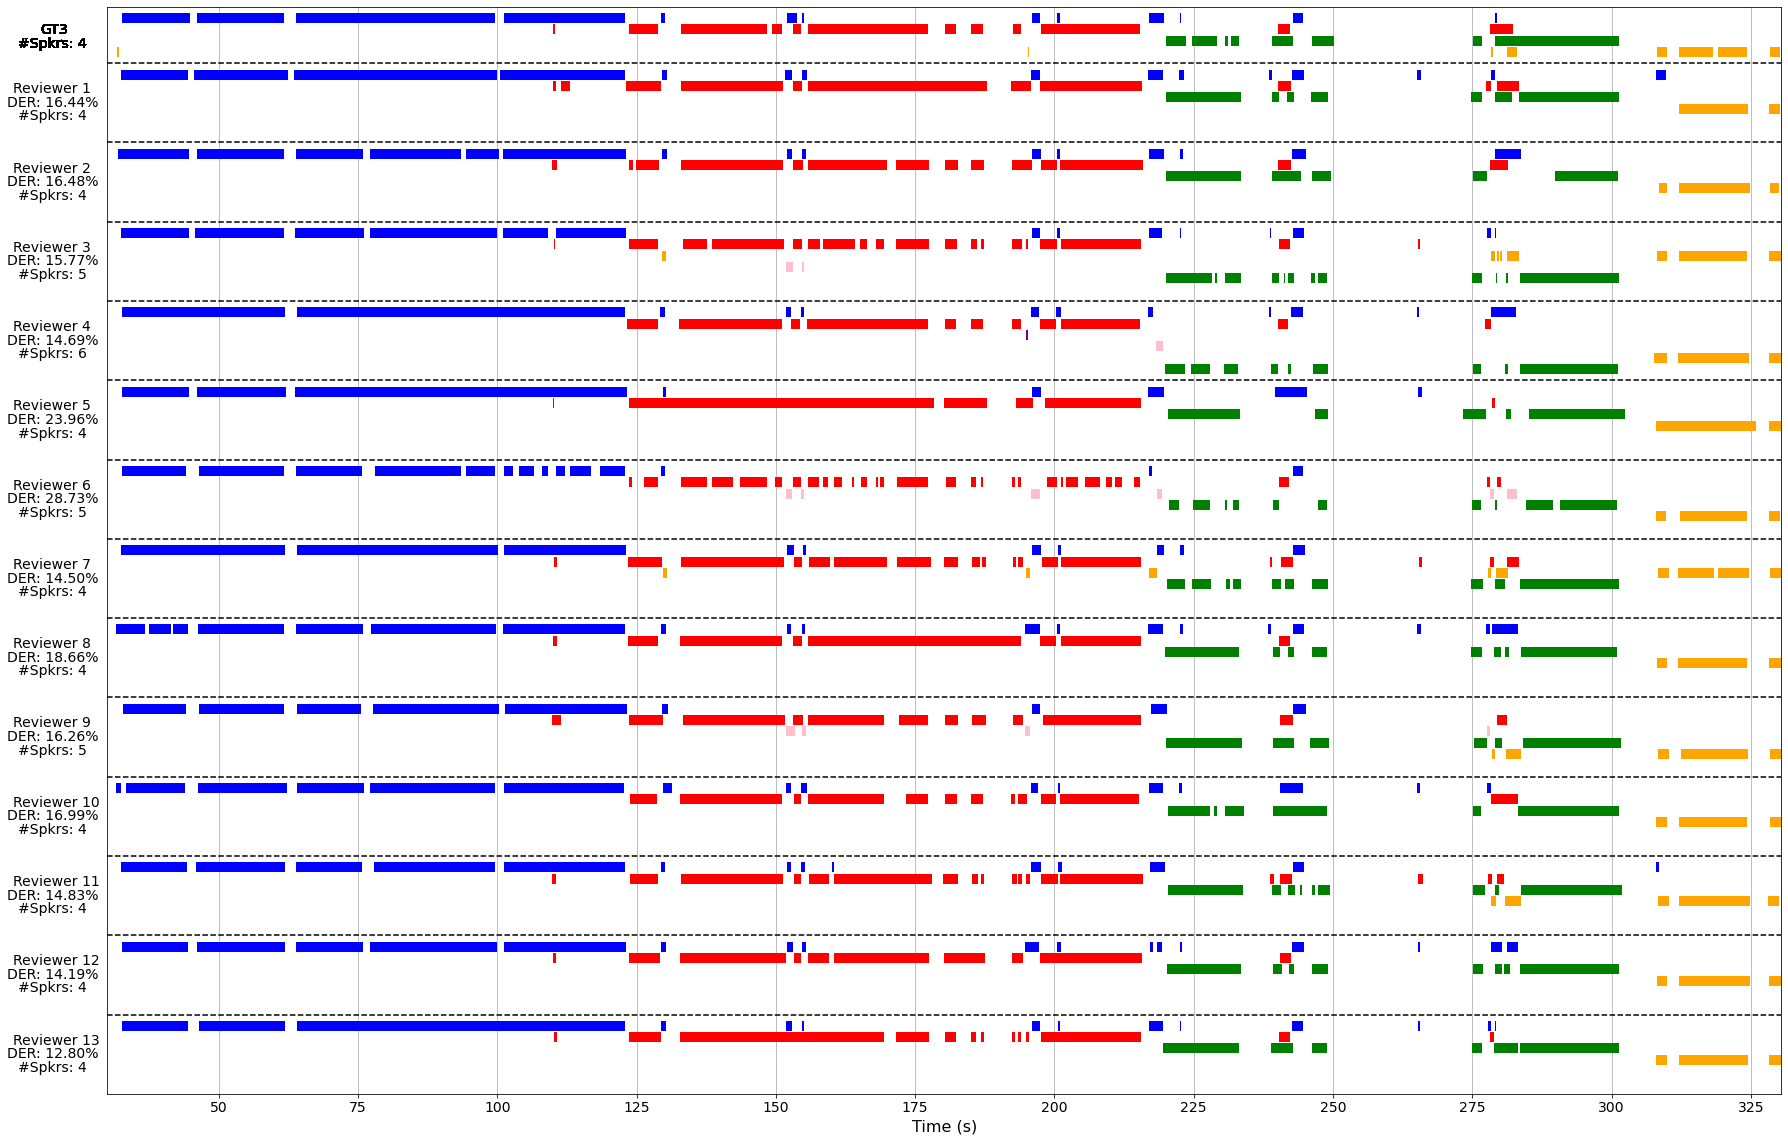

In [123]:
fig, ax = plt.subplots(figsize=(30, 20))

ax.set_xlim(30, 330.5)
ax.set_ylim([0, 48])
ax.invert_yaxis()
#ax.set_xticks[]

# Duration of extract
maxlen = 300.5

for row in timeSegsSpkr:
    if row[0] > 30 and row[0] < 330:
        #ax.axhline(3-spkr_to_num[row[2]]*0.5, (row[0]-30)/maxlen, (row[1]-30)/maxlen, c=colours[spkr_to_num[row[2]]], linewidth=20)
        ax.hlines(0.5 + spkr_to_num[row[2]]*0.5, row[0], row[1], color=colours[spkr_to_num[row[2]]], linewidth=10)
    #ax.hlines(2.75, 30, 330.5, color="k", linestyle="--")
    ax.text(18, 1.2, "GT3", fontsize=14)
    ax.text(14, 1.8, "#Spkrs: 4", fontsize=14)
        
for ind, tSS in enumerate(timeSegsSpkrs):
    pred_spkrs = set([row[2] for row in tSS])
    pred_spkr_to_num = {}
    for k, v in enumerate(pred_spkrs):
        pred_spkr_to_num[v] = k
    for row in tSS:
        ax.hlines(3+3.5*ind+pred_spkr_to_num[row[2]]*0.5, row[0], row[1], color=colours2[ind][pred_spkr_to_num[row[2]]], linewidth=10)
    ax.hlines(2.5+3.5*ind, 30, 330.5, color="k", linestyle="--")
    ax.text(13, 3.8+3.5*ind, "Reviewer {}".format(ind+1), fontsize=14)
    ax.text(12, 4.4+3.5*ind, "DER: {:.2f}%".format(ders[-1][ind][0]), fontsize=14)
    ax.text(14, 5.0+3.5*ind, "#Spkrs: {}".format(num_spkrs_pred[ind]), fontsize=14)
    
ax.set_xlabel("Time (s)", fontsize=16)
ax.set_xticks([25*i for i in range(2, 14)])
plt.setp(ax.get_xticklabels(), fontsize=14)
ax.set_yticks([])
ax.grid()

plt.savefig("../../HumanReviews/graphs/220515_Graph_predtimes_GT3.pdf", bbox_inches='tight', dpi=1200)

plt.show()

In [75]:
len(timeSegsSpkrs)

13

## AHC Only

In [ ]:
import evaluateResults

In [9]:
# ResNet101

outputDir = "VBx/ES2008/exp_gt3_AHConly/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
#uemFile = "../../HumanReviews/ES2008a.uem"
evaluateResults.runPerlCollarsUem(outputDir, audioname, oracleRttmFile)
df = AnalyseResults.getDERs(outputDir)
display(df)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.51,0.0,10.66,12.17
1,200,1.76,0.0,10.93,12.69
2,150,2.14,0.0,11.25,13.38
3,100,2.62,0.0,11.57,14.19
4,50,3.20,0.0,11.93,15.13
5,0,3.84,0.0,12.26,16.10


In [10]:
# ResNet101

outputDir = "VBx/ES2008/exp_gt3/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
#uemFile = "../../HumanReviews/ES2008a.uem"
evaluateResults.runPerlCollarsUem(outputDir, audioname, oracleRttmFile)
df = AnalyseResults.getDERs(outputDir)
display(df)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.51,0.0,1.26,2.77
1,200,1.76,0.0,1.43,3.18
2,150,2.14,0.0,1.60,3.74
3,100,2.62,0.0,1.83,4.45
4,50,3.20,0.0,2.11,5.31
5,0,3.84,0.0,2.39,6.23


In [8]:
# BDII

outputDir = "VBx_v1/ES2008/out_dir_gt3_noAHC/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
#uemFile = "../../HumanReviews/ES2008a.uem"
evaluateResults.runPerlCollarsUem(outputDir, audioname, oracleRttmFile)
df = AnalyseResults.getDERs(outputDir)
display(df)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.51,0.0,4.12,5.63
1,200,1.76,0.0,4.35,6.10
2,150,2.14,0.0,4.62,6.76
3,100,2.62,0.0,4.95,7.57
4,50,3.20,0.0,5.32,8.52
5,0,3.84,0.0,5.68,9.52


In [11]:
# Running DBII again after amending diarization_PLDAadapt_AHCxvec_BHMMxvec.py file so use_VB = True, which I think I got wrong before
# Ignore confusion in name "noAHC", was trying to say "AHConly" but actually have VB too

outputDir = "VBx_v1/ES2008/out_dir_gt3_noAHC/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
#uemFile = "../../HumanReviews/ES2008a.uem"
evaluateResults.runPerlCollarsUem(outputDir, audioname, oracleRttmFile)
df = AnalyseResults.getDERs(outputDir)
display(df)

Running md-eval-v21.pl scripts complete


,Collar (ms),MISSED (%),FALARM (%),ERROR (%),DER (%)
0,250,1.51,0.0,6.00,7.51
1,200,1.76,0.0,6.22,7.97
2,150,2.14,0.0,6.46,8.60
3,100,2.62,0.0,6.75,9.37
4,50,3.20,0.0,7.08,10.28
5,0,3.84,0.0,7.41,11.25


In [ ]:
# Running DBII again after amending diarization_PLDAadapt_AHCxvec_BHMMxvec.py file so use_VB = False to confirm previous odd results

outputDir = "VBx_v1/ES2008/out_dir_gt3_AHConly/"
audioname = "ES2008a"
oracleRttmFile = "testingModSpecLSTM/rttm/ES2008a.rttm"
#uemFile = "../../HumanReviews/ES2008a.uem"
evaluateResults.runPerlCollarsUem(outputDir, audioname, oracleRttmFile)
df = AnalyseResults.getDERs(outputDir)
display(df)

## GT Stats

In [4]:
import OverlapFunctions

In [3]:
tot_time = 0
with open("testingModSpecLSTM/rttm/ES2008a.rttm", "r") as f:
    for line in f:
        lineItems = line.split()
        tot_time += float(lineItems[4])
    tot_time = round(tot_time, 2)
    print(tot_time)     

806.64


In [27]:
import sys
sys.path.append('../RandomForest/')
import Audio

audiopath = "../../AMICorpusAllAudio/amicorpus/"
meetings = ["ES2008a", "ES2008b", "ES2008c", "ES2008d"]

audios = []
mic = "headset"
for meeting in meetings:
    fpath = audiopath + meeting + "/audio/"
    if mic == "headset":
        fname = meeting + ".Mix-Headset.wav"
    elif mic == "lapel":
        fname = meeting + ".Mix-Lapel.wav"
    elif mic == "array":
        raise ValueError("Array mics not implemented in code yet")

    fs, sig = Audio.getAudio(fpath, fname)
    audios.append(sig)
    
len(audios)

The audio file was sampled at 16,000 Hz with 16,693,760 samples overall and 1 channel.
The length of the file is 17 mins 23.36 secs.
The audio file was sampled at 16,000 Hz with 35,706,539 samples overall and 1 channel.
The length of the file is 37 mins 11.66 secs.
The audio file was sampled at 16,000 Hz with 33,641,941 samples overall and 1 channel.
The length of the file is 35 mins 2.62 secs.
The audio file was sampled at 16,000 Hz with 42,013,184 samples overall and 1 channel.
The length of the file is 43 mins 45.82 secs.


4

In [29]:
len(audios[0])/fs

1043.36

In [36]:
for gt in ["gt1", "gt3"]:
    print("{}".format(gt))
    for ind, m in enumerate(["a", "b", "c", "d"]):
        if gt == "gt1":
            rttmfile = "testingModSpecLSTM/rttm_laugh/ES2008" + m + ".rttm"
        else:
            rttmfile = "testingModSpecLSTM/rttm/ES2008" + m + ".rttm"
        timeSegsSpkr = OverlapFunctions.getSegsTimeSpkr(rttmfile)
        combinedSegs, _ = OverlapFunctions.findCombinedSegs(timeSegsSpkr)

        count = 0
        agg_time = 0
        for row in timeSegsSpkr:
            count += 1
            agg_time += round(row[1]-row[0], 3)

        comb_count = 0
        comb_agg_time = 0
        for row in combinedSegs:
            comb_count += 1
            comb_agg_time += round(row[1]-row[0], 3)
            
        overlap = (agg_time-comb_agg_time)/comb_agg_time
        change_rate = 2*count/((len(audios[ind])/fs))
        ave_seg_dur = agg_time/count

        print("There are {} vocal speech segments totalling {:.3f} secs, {} combined speech segs with total speech time {:.3f} secs, \
overlap {:.3f}%, change rate {:.3f} Hz, average segment duration {:.2f} secs.".\
              format(count, agg_time, comb_count, comb_agg_time, 100*overlap, change_rate, ave_seg_dur))
    print()

gt1
There are 194 vocal speech segments totalling 878.978 secs, 109 combined speech segs with total speech time 813.710 secs, overlap 8.021%, change rate 0.372 Hz, average segment duration 4.53 secs.
There are 474 vocal speech segments totalling 1978.480 secs, 229 combined speech segs with total speech time 1794.442 secs, overlap 10.256%, change rate 0.425 Hz, average segment duration 4.17 secs.
There are 431 vocal speech segments totalling 2172.691 secs, 152 combined speech segs with total speech time 1798.222 secs, overlap 20.824%, change rate 0.410 Hz, average segment duration 5.04 secs.
There are 860 vocal speech segments totalling 2664.415 secs, 333 combined speech segs with total speech time 2218.026 secs, overlap 20.126%, change rate 0.655 Hz, average segment duration 3.10 secs.

gt3
There are 168 vocal speech segments totalling 806.640 secs, 107 combined speech segs with total speech time 775.950 secs, overlap 3.955%, change rate 0.322 Hz, average segment duration 4.80 secs.
Th